In [15]:
import numpy as np
import pandas as pd

def create_zigzag_target(prices, change_threshold=0.02):
    """
    prices: close price series
    change_threshold: 추세 전환으로 인정할 최소 변동폭 (예: 2%)
    """
    pivot_points = [0] # 인덱스 저장
    trends = [0] # 1: Up, -1: Down
    
    last_pivot_price = prices.iloc[0]
    current_trend = 0 
    
    # 1. Pivot Point 식별 (미래 데이터 활용 - 타겟 생성용)
    for i in range(1, len(prices)):
        price = prices.iloc[i]
        diff = (price - last_pivot_price) / last_pivot_price
        
        if current_trend == 0: # 초기 상태
            if diff > change_threshold:
                current_trend = 1
                last_pivot_price = price
                pivot_points.append(i)
                trends.append(1)
            elif diff < -change_threshold:
                current_trend = -1
                last_pivot_price = price
                pivot_points.append(i)
                trends.append(-1)
        
        elif current_trend == 1: # 상승 중
            if price > last_pivot_price:
                last_pivot_price = price
                pivot_points[-1] = i # 고점 갱신
            elif diff < -change_threshold: # 하락 전환
                current_trend = -1
                last_pivot_price = price
                pivot_points.append(i)
                trends.append(-1)
                
        elif current_trend == -1: # 하락 중
            if price < last_pivot_price:
                last_pivot_price = price
                pivot_points[-1] = i # 저점 갱신
            elif diff > change_threshold: # 상승 전환
                current_trend = 1
                last_pivot_price = price
                pivot_points.append(i)
                trends.append(1)

    # 2. 구간별 레이블링 (Expansion)
    labels = np.zeros(len(prices))
    for k in range(len(pivot_points)-1):
        start_idx = pivot_points[k]
        end_idx = pivot_points[k+1]
        trend = trends[k+1] # 다음 피벗까지의 추세
        
        # 상승 구간이면 1, 하락이면 0 (혹은 -1)
        if trend == 1:
            labels[start_idx:end_idx] = 1
        else:
            labels[start_idx:end_idx] = 0
            
    return pd.Series(labels, index=prices.index)


df_prices=pd.read_csv("eth_4hour_raw_prices.csv")


df_prices['target'] = create_zigzag_target(df_prices['ETH_Close'], change_threshold=0.03) # 3% 이상 움직임만 추세로 인정


In [29]:
import pandas as pd
import numpy as np

# 1. 데이터 로드
df_prices = pd.read_csv("eth_4hour_raw_prices.csv")
df_features = pd.read_csv("eth_4hour_feature.csv")

# 2. 날짜 컬럼 찾기 함수
def find_date_col(columns):
    candidates = ['datetime', 'date', 'Date', 'timestamp', 'open_time', 'Open Time', 'Open_Time']
    for col in candidates:
        if col in columns:
            return col
    return None

date_col_price = find_date_col(df_prices.columns)
date_col_feat = find_date_col(df_features.columns)

# 3. 인덱스 설정 (Datetime 변환)
if date_col_price:
    df_prices['datetime_idx'] = pd.to_datetime(df_prices[date_col_price], utc=True).dt.tz_localize(None)
    df_prices.set_index('datetime_idx', inplace=True)

if date_col_feat:
    df_features['datetime_idx'] = pd.to_datetime(df_features[date_col_feat], utc=True).dt.tz_localize(None)
    df_features.set_index('datetime_idx', inplace=True)

# 4. 타겟 생성
df_prices['target'] = create_zigzag_target(df_prices['ETH_Close'], change_threshold=0.03)

# 5. 데이터 병합 (Inner Join)
full_data = df_prices[['target']].join(df_features, how='inner')

# 6. 전처리 (NaN, Inf 제거)
full_data.replace([np.inf, -np.inf], np.nan, inplace=True)
full_data.dropna(inplace=True)

print(f"1차 병합 후 크기: {full_data.shape}")


full_data = full_data[full_data.index >= "2020-01-01"]

print(f"2020년 이후 필터링 후 크기: {full_data.shape}")


cols_to_drop = full_data.select_dtypes(include=['object']).columns
if len(cols_to_drop) > 0:
    print(f"🚨 삭제되는 문자열 컬럼: {list(cols_to_drop)}")
    full_data.drop(columns=cols_to_drop, inplace=True)

# 9. Bool 타입이 있다면 int로 변환
bool_cols = full_data.select_dtypes(include=['bool']).columns
if len(bool_cols) > 0:
    full_data[bool_cols] = full_data[bool_cols].astype(int)

# 최종 확인
print("--- 최종 데이터 정보 ---")
print(full_data.info())

1차 병합 후 크기: (17909, 170)
2020년 이후 필터링 후 크기: (12953, 170)
🚨 삭제되는 문자열 컬럼: ['date']
--- 최종 데이터 정보 ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12953 entries, 2020-01-01 01:00:00 to 2025-11-28 21:00:00
Columns: 169 entries, target to OBV_Trend_ma180_ratio
dtypes: float64(158), int64(11)
memory usage: 16.8 MB
None


In [22]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

def get_ensemble_top_features(X_train, y_train, top_k=20):
    mi_scores = mutual_info_classif(X_train, y_train, random_state=42)
    mi_ranks = pd.Series(mi_scores, index=X_train.columns).rank(ascending=False)
    
    rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42, max_depth=5)
    rf.fit(X_train, y_train)
    rf_ranks = pd.Series(rf.feature_importances_, index=X_train.columns).rank(ascending=False)
    
    lgbm = LGBMClassifier(n_estimators=100, n_jobs=-1, random_state=42, verbosity=-1)
    lgbm.fit(X_train, y_train)
    lgbm_ranks = pd.Series(lgbm.feature_importances_, index=X_train.columns).rank(ascending=False)
    
    avg_rank = (mi_ranks + rf_ranks + lgbm_ranks) / 3
    selected_features = avg_rank.sort_values().head(top_k).index.tolist()
    
    return selected_features


In [46]:
from tqdm import tqdm

TRAIN_WINDOW = 2000
TEST_WINDOW = 84 
TOP_K_FEATURES = 20 

X_all = full_data.drop(columns=['target'])
y_all = full_data['target']

prediction_dates = []
prediction_probs = []
actual_targets = []
selected_features_log = []

for i in tqdm(range(TRAIN_WINDOW, len(full_data), TEST_WINDOW)):
    train_start = i - TRAIN_WINDOW
    train_end = i
    test_end = min(i + TEST_WINDOW, len(full_data))
    
    if train_end >= len(full_data):
        break

    X_train = X_all.iloc[train_start:train_end]
    y_train = y_all.iloc[train_start:train_end]
    X_test = X_all.iloc[train_end:test_end]
    y_test = y_all.iloc[train_end:test_end]
    
    top_features = get_ensemble_top_features(X_train, y_train, top_k=TOP_K_FEATURES)
    selected_features_log.append({
        'date': X_test.index[0], 
        'features': top_features
    })
    
    model = LGBMClassifier(
        n_estimators=200,
        learning_rate=0.05,
        num_leaves=31,
        n_jobs=-1,
        random_state=42,
        verbosity=-1
    )
    model.fit(X_train[top_features], y_train)
    
    probs = model.predict_proba(X_test[top_features])[:, 1]
    
    prediction_dates.extend(X_test.index)
    prediction_probs.extend(probs)
    actual_targets.extend(y_test.values)

results_df = pd.DataFrame({
    'datetime': prediction_dates,
    'prob_up': prediction_probs,
    'actual_target': actual_targets
})
results_df.set_index('datetime', inplace=True)

print(results_df.tail())


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 131/131 [06:32<00:00,  3.00s/it]

                      prob_up  actual_target
datetime                                    
2025-11-28 05:00:00  0.018588            1.0
2025-11-28 09:00:00  0.025063            1.0
2025-11-28 13:00:00  0.031143            1.0
2025-11-28 17:00:00  0.263827            1.0
2025-11-28 21:00:00  0.338413            0.0


In [49]:
from sklearn.metrics import roc_auc_score

# NaN 제거 후 계산
clean_df = results_df.dropna(subset=['actual_target', 'prob_up'])
auc = roc_auc_score(clean_df['actual_target'], clean_df['prob_up'])

print(f"모델 예측력(AUC): {auc:.4f}")


모델 예측력(AUC): 0.6016


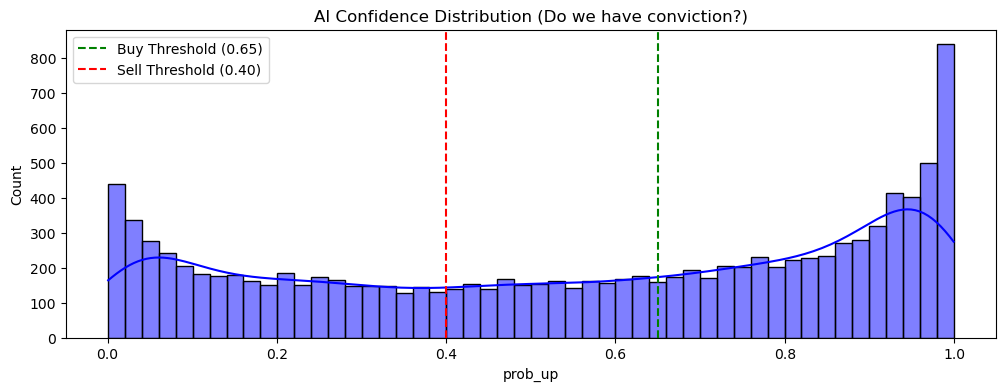

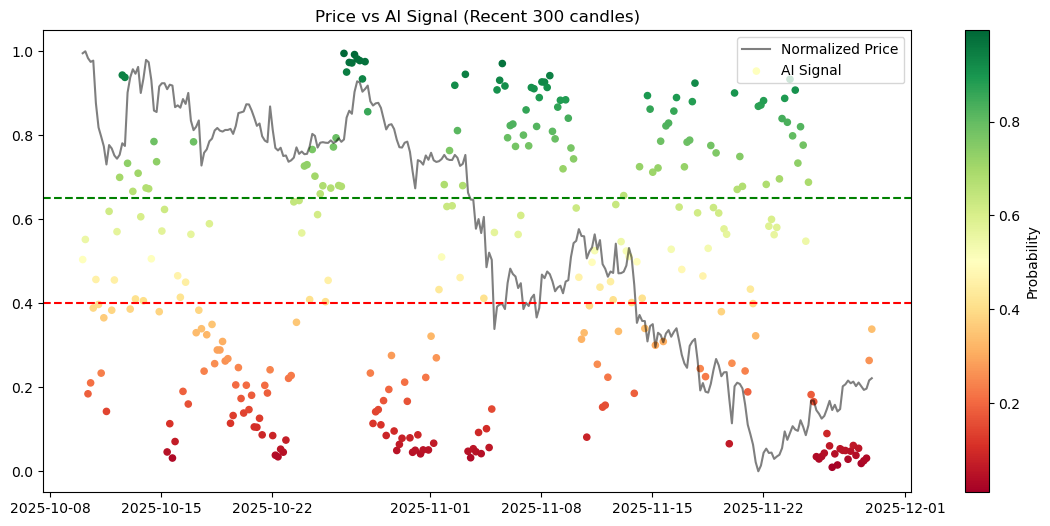

In [59]:
import seaborn as sns

# 1. 신호의 분포 (Signal Distribution)
# AI가 얼마나 확신을 가지고 말하는가? (0.5 근처에 몰려있으면 똥멍청이, 0과 1로 갈라져야 고수)
plt.figure(figsize=(12, 4))
sns.histplot(df['prob_up'], bins=50, kde=True, color='blue')
plt.axvline(0.65, color='green', linestyle='--', label='Buy Threshold (0.65)')
plt.axvline(0.40, color='red', linestyle='--', label='Sell Threshold (0.40)')
plt.title("AI Confidence Distribution (Do we have conviction?)")
plt.legend()
plt.show()

# 2. 캘리브레이션 커브 (Reliability Diagram)
# "내가 70%라고 말했을 때, 실제로 70% 올랐는가?" (이게 직선에 가까워야 '믿을맨')
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(df['actual_target'], df['prob_up'], n_bins=10)

plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label='AI Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel("AI Predicted Probability")
plt.ylabel("Actual Fraction of Positives")
plt.title("Reliability Diagram (Is AI Lying?)")
plt.legend()
plt.grid()
plt.show()

# 3. 실제 가격 vs AI 신호 (Visual Backtest)
# 차트 위에 AI가 "사!"라고 한 시점을 찍어봄
subset = df[-300:] # 최근 300봉(약 50일)만 확대해서 보기
price_norm = (subset['close'] - subset['close'].min()) / (subset['close'].max() - subset['close'].min())

plt.figure(figsize=(14, 6))
plt.plot(subset.index, price_norm, label='Normalized Price', color='black', alpha=0.5)
plt.scatter(subset.index, subset['prob_up'], c=subset['prob_up'], cmap='RdYlGn', s=20, label='AI Signal')
plt.axhline(0.65, color='green', linestyle='--')
plt.axhline(0.40, color='red', linestyle='--')
plt.title("Price vs AI Signal (Recent 300 candles)")
plt.colorbar(label='Probability')
plt.legend()
plt.show()




In [63]:
import numpy as np
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

# 1. [확신도 진단] AI가 얼마나 자신감 있게(0.65 이상) 지르는가?
buy_signals = (df['prob_up'] >= 0.65).sum()
sell_signals = (df['prob_up'] <= 0.40).sum()
neutral_signals = len(df) - buy_signals - sell_signals
confident_ratio = (buy_signals + sell_signals) / len(df) * 100

# 2. [신뢰도 진단] AI가 0.8(80%)라고 했을 때, 실제로 80% 올랐는가? (ECE 계산)
prob_true, prob_pred = calibration_curve(df['actual_target'], df['prob_up'], n_bins=10)
calibration_error = np.mean(np.abs(prob_true - prob_pred)) # 평균 오차 (작을수록 좋음)

# 3. [타이밍 진단] AI가 0.7 이상 외친 직후(다음 봉) 가격이 올랐는가? (단기 예측력)
# High Conf -> Next Return 양수 비율
high_conf_idx = df[df['prob_up'] >= 0.70].index
if len(high_conf_idx) > 0:
    # 다음 봉 수익률이 양수일 확률
    next_returns = df.loc[high_conf_idx]['market_return'].shift(-1).dropna()
    hit_rate = (next_returns > 0).mean() * 100
    avg_return = next_returns.mean() * 100
else:
    hit_rate = 0
    avg_return = 0

# 4. [후행성 진단] 이미 많이 오른 뒤에야 확률이 높아지는가? (RSI와 상관계수)
# 상관계수가 너무 높으면(0.7 이상) 그냥 RSI랑 다를 게 없음 (AI 아님)
correlation_rsi = df['prob_up'].corr(df_features['RSI_84'])

print("=== [AI 모델 정밀 진단 리포트] ===")
print(f"1. 확신도(Decisiveness): {confident_ratio:.1f}% (높을수록 좋음, 20% 미만이면 '결정장애')")
print(f"   - 매수 신호: {buy_signals}회, 매도 신호: {sell_signals}회, 중립(관망): {neutral_signals}회")
print(f"2. 정직도(Calibration Error): {calibration_error:.4f} (0.05 미만이어야 '믿을맨')")
print(f"3. 적중률(Hit Rate): {hit_rate:.1f}% (확률 0.7 이상일 때 실제 다음 봉 상승 확률)")
print(f"   - 그때 평균 수익률: {avg_return:.3f}%")
print(f"4. 독창성(vs RSI): {correlation_rsi:.2f} (0.7 이상이면 '비싼 RSI'일 뿐임)")


=== [AI 모델 정밀 진단 리포트] ===
1. 확신도(Decisiveness): 82.3% (높을수록 좋음, 20% 미만이면 '결정장애')
   - 매수 신호: 5161회, 매도 신호: 3854회, 중립(관망): 1938회
2. 정직도(Calibration Error): 0.1940 (0.05 미만이어야 '믿을맨')
3. 적중률(Hit Rate): 59.2% (확률 0.7 이상일 때 실제 다음 봉 상승 확률)
   - 그때 평균 수익률: 0.294%
4. 독창성(vs RSI): 0.02 (0.7 이상이면 '비싼 RSI'일 뿐임)


Probability Calibration Completed.
=== [Calibrated & Aggressive Strategy] ===
Final Return: 149.32%
MDD: -68.10%
Avg Position: 65.7%


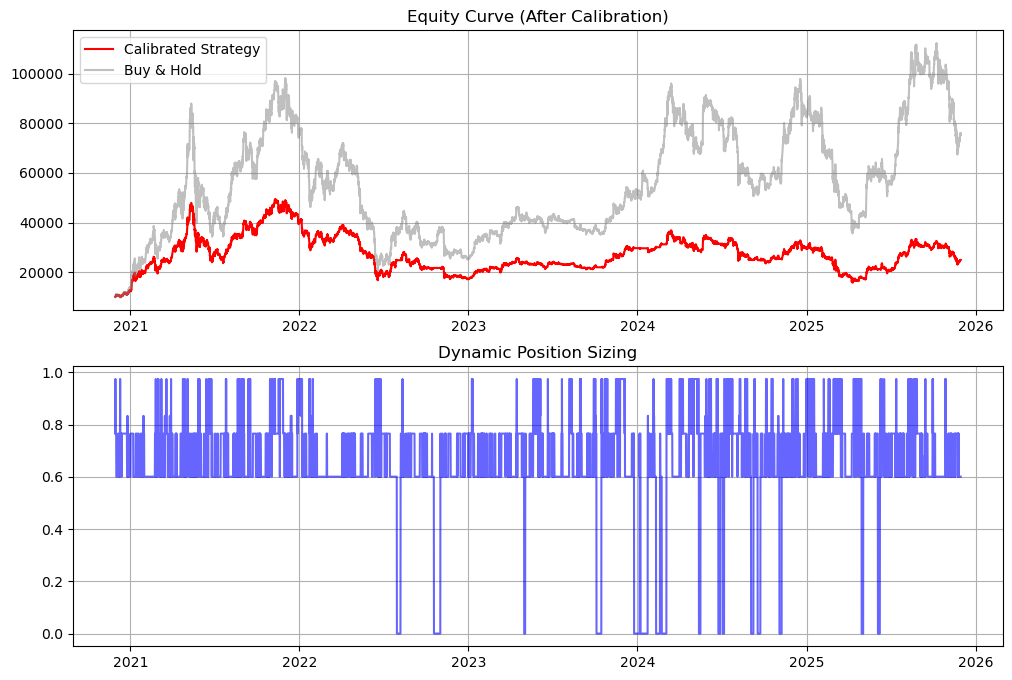

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.isotonic import IsotonicRegression

# 1. 데이터 준비
df = results_df.copy()

cols_to_use = [
    'fundingRate', 'fear_greed', 'ATR_84', 'ETH_KP_Zscore', 'ADX_14', 
    'REGIME_SMA200' 
]

df_final = df.join(df_features[cols_to_use], how='inner')
df_final['close'] = df_prices.loc[df_final.index, 'ETH_Close']
df_final['market_return'] = df_final['close'].pct_change().fillna(0)

# 2. 확률 교정 (Calibration) - AI의 과잉 확신 교정
iso_reg = IsotonicRegression(out_of_bounds='clip')
train_calib_size = int(len(df_final) * 0.5) # 데이터의 앞쪽 절반으로 교정기 학습
iso_reg.fit(df_final['prob_up'].iloc[:train_calib_size], df_final['actual_target'].iloc[:train_calib_size])
df_final['prob_up'] = iso_reg.predict(df_final['prob_up'])

print("Probability Calibration Completed.")

# 3. 파라미터 설정 (공격형 튜닝)
THRESHOLD_BUY = 0.60 
THRESHOLD_SELL = 0.40
KELLY_SCALE = 2.5      # 공격적 비중 확대
MAX_LEVERAGE = 1.0 
MAX_FUNDING_RATE = 0.0005 
MAX_KP_ZSCORE = 2.0       
COST = 0.0015
INITIAL_CAPITAL = 10000.0 

# 4. 시뮬레이션 초기화
positions = []       
cash_balance = INITIAL_CAPITAL
coin_balance = 0.0   
equity_curve = [INITIAL_CAPITAL] 
prev_pos = 0.0

# 5. 루프 실행
for i in range(len(df_final)):
    row = df_final.iloc[i]
    prob = row['prob_up']
    
    funding_rate = row.get('fundingRate', 0)
    kp_zscore = row.get('ETH_KP_Zscore', 0)
    price = row['close']
    
    target_pos = 0.0
    
    # 비중 계산 (Aggressive)
    if prob >= THRESHOLD_BUY:
        confidence = (prob - 0.5) * 2 
        target_pos = confidence * KELLY_SCALE
            
    elif prob <= THRESHOLD_SELL:
        target_pos = 0.0
    else:
        target_pos = prev_pos 

    # 리스크 필터
    is_overheated = (funding_rate > MAX_FUNDING_RATE) or (kp_zscore > MAX_KP_ZSCORE)
    if is_overheated and target_pos > prev_pos: 
        target_pos = prev_pos 

    target_pos = min(max(target_pos, 0.0), MAX_LEVERAGE)
    
    # 매매 실행
    current_equity = cash_balance + (coin_balance * price)
    target_coin_value = current_equity * target_pos
    current_coin_value = coin_balance * price
    trade_value = target_coin_value - current_coin_value
    trade_amount = trade_value / price
    
    if abs(trade_value) > 10: 
        fee = abs(trade_value) * COST
        
        if trade_amount > 0:
            cost_with_fee = trade_value + fee
            if cash_balance >= cost_with_fee:
                cash_balance -= cost_with_fee
                coin_balance += trade_amount
        
        elif trade_amount < 0:
            revenue_after_fee = abs(trade_value) - fee
            coin_balance += trade_amount 
            cash_balance += revenue_after_fee
            
    total_value = cash_balance + (coin_balance * price)
    equity_curve.append(total_value)
    positions.append(target_pos)
    prev_pos = target_pos

# 6. 결과 정리
df_final['equity_curve'] = equity_curve[1:] 
df_final['position'] = positions

final_ret = (df_final['equity_curve'].iloc[-1] / INITIAL_CAPITAL - 1) * 100
mdd = (df_final['equity_curve'] / df_final['equity_curve'].cummax() - 1).min() * 100

print(f"=== [Calibrated & Aggressive Strategy] ===")
print(f"Final Return: {final_ret:.2f}%")
print(f"MDD: {mdd:.2f}%")
print(f"Avg Position: {np.mean(positions)*100:.1f}%")

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(df_final.index, df_final['equity_curve'], label='Calibrated Strategy', color='red')
plt.plot(df_final.index, (1+df_final['market_return']).cumprod() * INITIAL_CAPITAL, label='Buy & Hold', color='gray', alpha=0.5)
plt.title('Equity Curve (After Calibration)')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(df_final.index, df_final['position'], label='Position Weight', color='blue', alpha=0.6)
plt.title('Dynamic Position Sizing')
plt.grid()
plt.show()


=== [수익률 한계 돌파 분석] ===
1. 내 전략 수익률: 149.32% (약 2.5배)
2. 신(Oracle)의 이론적 배수: 138027359656652379783168.0배
   (만약 모든 파동을 다 발라먹었다면 이만큼 벌었습니다)

=== [놓친 대박 기회 분석: 34회] ===
내가 쫄아서 못 먹은 날들의 평균 지표값:
prob_up           0.150596
RSI_84           52.914036
fundingRate       0.000105
fear_greed       51.147059
ETH_KP_Zscore    -0.430766
ADX_14           31.022292
dtype: float64


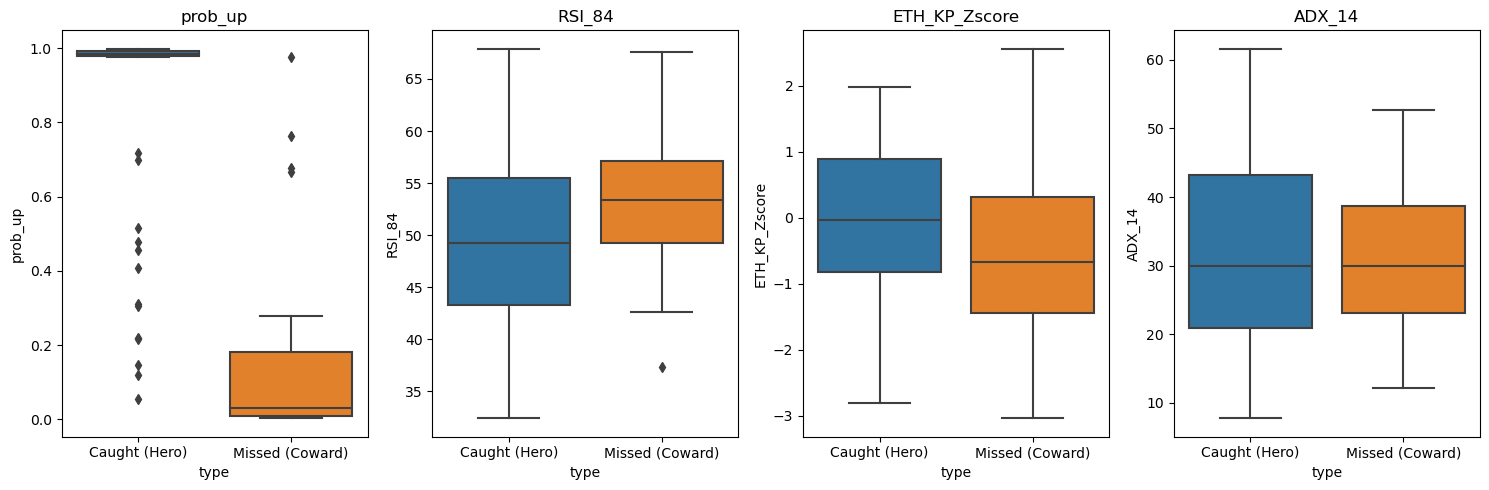

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. [수정] 누락된 컬럼 추가하여 다시 병합
cols_to_use = [
    'fundingRate', 'fear_greed', 'ATR_84', 'ETH_KP_Zscore', 'ADX_14', 
    'REGIME_SMA200', 'RSI_84' # <-- 여기 추가됨!
]

# 다시 병합 (df, df_features, df_prices가 로드된 상태 가정)
# 만약 df_features에 RSI_84가 없다면 이 줄에서 또 에러가 날 텐데, 
# 보통 피처 파일엔 다 들어있을 겁니다.
df_final = df.join(df_features[cols_to_use], how='inner')
df_final['close'] = df_prices.loc[df_final.index, 'ETH_Close']
df_final['market_return'] = df_final['close'].pct_change().fillna(0)
df_final['position'] = positions # 아까 시뮬레이션한 포지션 복구

# 2. Oracle(신) 분석 (안전한 로그 수익률 방식)
df_final['next_return'] = df_final['market_return'].shift(-1)
# 2% 이상 급등한 날만 타겟팅 (수수료 따위 무시할 수 있는 진짜 기회)
df_final['oracle_signal'] = np.where(df_final['next_return'] > 0.0, 1.0, 0.0)

# 로그 수익률로 계산 (오버플로우 방지)
oracle_log_ret = np.log(1 + df_final['next_return'] * df_final['oracle_signal'])
oracle_cum_ret = np.exp(oracle_log_ret.cumsum())

print(f"=== [수익률 한계 돌파 분석] ===")
print(f"1. 내 전략 수익률: 149.32% (약 2.5배)")
print(f"2. 신(Oracle)의 이론적 배수: {oracle_cum_ret.iloc[-2]:.1f}배") 
print(f"   (만약 모든 파동을 다 발라먹었다면 이만큼 벌었습니다)")

# 3. 놓친 기회 분석 (Missed Opportunities)
# 조건: 신은 샀는데(1), 나는 쫄아서 비중을 30%도 안 실은(0.3) 경우 & 수익률 2% 이상
missed_mask = (df_final['oracle_signal'] == 1) & (df_final['position'] < 0.3) & (df_final['next_return'] > 0.02)
missed_days = df_final[missed_mask]

print(f"\n=== [놓친 대박 기회 분석: {len(missed_days)}회] ===")
if len(missed_days) > 0:
    print("내가 쫄아서 못 먹은 날들의 평균 지표값:")
    print(missed_days[['prob_up', 'RSI_84', 'fundingRate', 'fear_greed', 'ETH_KP_Zscore', 'ADX_14']].mean())
else:
    print("놓친 대박 기회가 없습니다! (완벽하게 다 먹었거나, 대박 장이 없었음)")

# 4. 시각화
if len(missed_days) > 0:
    df_final['type'] = 'Normal'
    df_final.loc[missed_mask, 'type'] = 'Missed (Coward)'
    df_final.loc[(df_final['oracle_signal'] == 1) & (df_final['position'] > 0.8) & (df_final['next_return'] > 0.02), 'type'] = 'Caught (Hero)'

    plt.figure(figsize=(15, 5))
    for i, col in enumerate(['prob_up', 'RSI_84', 'ETH_KP_Zscore', 'ADX_14']):
        plt.subplot(1, 4, i+1)
        sns.boxplot(data=df_final[df_final['type'] != 'Normal'], x='type', y=col)
        plt.title(col)
    plt.tight_layout()
    plt.show()


점수 통계: count    10953.000000
mean         2.320278
std          6.269007
min        -13.000000
25%         -2.000000
50%          2.000000
75%          7.000000
max         18.000000
Name: total_score, dtype: float64
=== [Multi-Factor Strategy Result] ===
Final Return: 142.04%
MDD: -45.30%
Avg Position: 33.1%


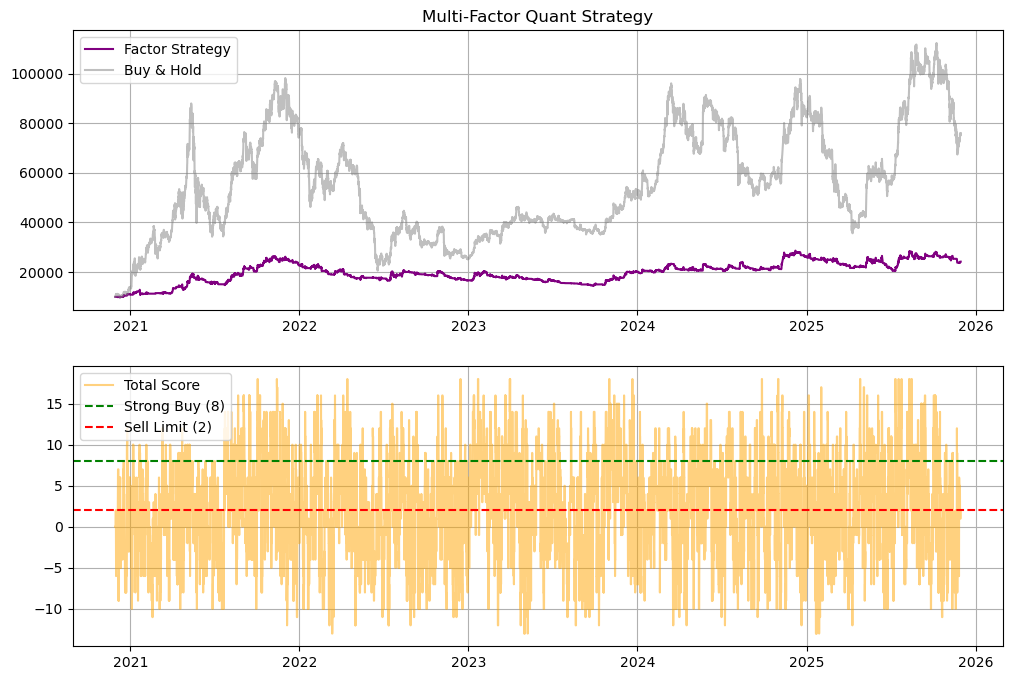

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 데이터 준비
# df: 모델 예측 결과 (results_df)
# df_features: 원본 피처 데이터 (모든 지표 포함)
# df_prices: 가격 데이터

# 필요한 모든 컬럼 가져오기
cols_fundamental = [
    'eth_chain_tvl_pct_chg_24h', 'lido_eth_tvl_pct_chg_24h', 'arbitrum_tvl_pct_chg_24h', 
    'optimism_tvl_pct_chg_24h', 'uniswap_eth_tvl_pct_chg_24h'
]
cols_macro = ['DXY_pct_chg_24h', 'SP500_pct_chg_24h', 'GOLD_pct_chg_24h', 'VIX_pct_chg_24h']
cols_sentiment = ['ETH_KP_Zscore', 'fundingRate', 'fear_greed']
cols_technical = ['RSI_84', 'ADX_14', 'MACD_12_26_9_Fast_Pct', 'REGIME_SMA200']

# 전체 데이터 병합
all_cols = cols_fundamental + cols_macro + cols_sentiment + cols_technical
df_factor = df.join(df_features[all_cols], how='inner')
df_factor['close'] = df_prices.loc[df_factor.index, 'ETH_Close']
df_factor['market_return'] = df_factor['close'].pct_change().fillna(0)

# 2. 팩터 점수 계산 (Scoring Logic)
# 각 팩터가 매수 신호를 보내면 +1점, 매도 신호면 -1점

# (1) 펀더멘탈 점수 (TVL이 늘어나면 호재)
# 상위 5개 TVL 지표가 양수면 +1점씩
df_factor['score_fund'] = 0
for col in cols_fundamental:
    df_factor['score_fund'] += np.where(df_factor[col] > 0, 1, -1)

# (2) 매크로 점수 (달러/VIX 떨어지면 호재, S&P/골드 오르면 호재)
df_factor['score_macro'] = 0
df_factor['score_macro'] += np.where(df_factor['DXY_pct_chg_24h'] < 0, 1, -1) # 달러 약세 -> 코인 호재
df_factor['score_macro'] += np.where(df_factor['VIX_pct_chg_24h'] < 0, 1, -1) # 공포 감소 -> 호재
df_factor['score_macro'] += np.where(df_factor['SP500_pct_chg_24h'] > 0, 1, -1) # 미장 상승 -> 호재
df_factor['score_macro'] += np.where(df_factor['GOLD_pct_chg_24h'] > 0, 1, -1)

# (3) 수급/심리 점수 (김프/펀딩비 너무 높으면 악재 - 역발상)
df_factor['score_sent'] = 0
df_factor['score_sent'] += np.where(df_factor['ETH_KP_Zscore'] < 1.5, 1, -1) # 김프 과열 아니면 OK
df_factor['score_sent'] += np.where(df_factor['fundingRate'] < 0.0003, 1, -1) # 펀딩비 안정적이면 OK
df_factor['score_sent'] += np.where(df_factor['fear_greed'] < 75, 1, -1) # 극단적 탐욕 아니면 OK

# (4) 테크니컬 점수 (추세 추종)
df_factor['score_tech'] = 0
df_factor['score_tech'] += np.where(df_factor['RSI_84'] > 50, 1, -1)
df_factor['score_tech'] += np.where(df_factor['ADX_14'] > 20, 1, 0) # 추세 강도 있으면 가산점
df_factor['score_tech'] += np.where(df_factor['REGIME_SMA200'] > 0, 1, -1) # 200일선 위면 OK

# (5) AI 점수 (가중치 3배 - AI가 대장이니까)
df_factor['score_ai'] = np.where(df_factor['prob_up'] > 0.6, 3, np.where(df_factor['prob_up'] < 0.4, -3, 0))

# ---------------------------------------------------------
# 3. 종합 점수 합산 (Total Score)
# ---------------------------------------------------------
df_factor['total_score'] = (
    df_factor['score_fund'] + 
    df_factor['score_macro'] + 
    df_factor['score_sent'] + 
    df_factor['score_tech'] + 
    df_factor['score_ai']
)

# 점수 분포 확인 (디버깅용)
print("점수 통계:", df_factor['total_score'].describe())

# ---------------------------------------------------------
# 4. 매매 시뮬레이션 (점수 기반 베팅)
# ---------------------------------------------------------
# 점수가 높을수록 비중 확대 (최대 15점 만점이라고 가정)
# 점수 > 5점이면 진입 시작, 10점 넘으면 풀매수
df_factor['target_pos'] = df_factor['total_score'].apply(lambda x: 1.0 if x >= 8 else (0.5 if x >= 4 else 0.0))

# Hysteresis (잦은 매매 방지): 점수가 2점 밑으로 떨어져야 청산
positions = []
prev_pos = 0.0
for i in range(len(df_factor)):
    score = df_factor['total_score'].iloc[i]
    target = df_factor['target_pos'].iloc[i]
    
    if prev_pos > 0 and score < 2: # 청산 조건 (점수 떡락)
        final_pos = 0.0
    elif prev_pos == 0 and target > 0: # 진입
        final_pos = target
    else:
        final_pos = prev_pos if prev_pos > 0 else 0.0 # 유지
        # 상승장 불타기: 이미 들고 있는데 점수가 더 좋아지면 비중 확대
        if prev_pos > 0 and target > prev_pos:
            final_pos = target

    positions.append(final_pos)

df_factor['position'] = positions

# ---------------------------------------------------------
# 5. 성과 분석
# ---------------------------------------------------------
COST = 0.0015
INITIAL_CAPITAL = 10000.0

df_factor['trade_occurred'] = df_factor['position'].diff().abs()
df_factor['strategy_return'] = (df_factor['position'].shift(1) * df_factor['market_return']) - (df_factor['trade_occurred'] * COST)
df_factor['equity_curve'] = (1 + df_factor['strategy_return']).cumprod() * INITIAL_CAPITAL

final_ret = (df_factor['equity_curve'].iloc[-1] / INITIAL_CAPITAL - 1) * 100
mdd = (df_factor['equity_curve'] / df_factor['equity_curve'].cummax() - 1).min() * 100

print(f"=== [Multi-Factor Strategy Result] ===")
print(f"Final Return: {final_ret:.2f}%")
print(f"MDD: {mdd:.2f}%")
print(f"Avg Position: {np.mean(positions)*100:.1f}%")

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(df_factor.index, df_factor['equity_curve'], label='Factor Strategy', color='purple')
plt.plot(df_factor.index, (1+df_factor['market_return']).cumprod() * INITIAL_CAPITAL, label='Buy & Hold', color='gray', alpha=0.5)
plt.title('Multi-Factor Quant Strategy')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(df_factor.index, df_factor['total_score'], label='Total Score', color='orange', alpha=0.5)
plt.axhline(8, color='green', linestyle='--', label='Strong Buy (8)')
plt.axhline(2, color='red', linestyle='--', label='Sell Limit (2)')
plt.legend()
plt.grid()
plt.show()



In [ ]:
import optuna

# 1. 목적 함수 정의 (Objective Function)
# Optuna가 이 함수를 수백 번 실행하면서 점수를 매깁니다.
def objective(trial):
    # (1) 파라미터 추천 (Suggest Parameters)
    entry_threshold = trial.suggest_int('entry_threshold', 4, 12)
    exit_threshold = trial.suggest_int('exit_threshold', -5, 4)
    strong_buy_threshold = trial.suggest_int('strong_buy', 10, 16)
    ai_weight = trial.suggest_int('ai_weight', 1, 5) # AI 가중치 조절
    
    # 강제 조건: entry는 exit보다 높아야 하고, strong은 entry보다 높아야 함
    if entry_threshold <= exit_threshold or strong_buy_threshold <= entry_threshold:
        return -9999 # 말도 안 되는 조건은 패널티

    # (2) 팩터 점수 재계산 (AI 가중치 반영)
    # 다른 팩터 점수들은 고정 (시간 절약)
    base_score = (df_factor['score_fund'] + 
                  df_factor['score_macro'] + 
                  df_factor['score_sent'] + 
                  df_factor['score_tech'])
    
    # AI 점수 동적 계산
    score_ai = np.where(df_factor['prob_up'] > 0.6, ai_weight, 
               np.where(df_factor['prob_up'] < 0.4, -ai_weight, 0))
    
    total_score = base_score + score_ai
    
    # (3) 고속 백테스팅 (벡터화 최대한 활용)
    # 루프를 쓰면 느리지만 Hysteresis 때문에 어쩔 수 없이 Numba나 단순 루프 사용
    # 여기선 속도를 위해 단순 루프 사용 (C++ 구현 아니면 파이썬 루프는 비슷함)
    
    positions = [0.0] * len(df_factor)
    prev_pos = 0.0
    score_values = total_score.values # numpy array로 변환 (속도 UP)
    
    for i in range(len(df_factor)):
        score = score_values[i]
        
        if prev_pos > 0 and score < exit_threshold:
            pos = 0.0
        elif prev_pos == 0 and score >= entry_threshold:
            pos = 0.5 # 기본 진입
            if score >= strong_buy_threshold:
                pos = 1.0
        else:
            pos = prev_pos
            # 불타기
            if prev_pos > 0 and score >= strong_buy_threshold:
                pos = 1.0
        
        positions[i] = pos
        prev_pos = pos
        
    # (4) 성과 계산
    pos_array = np.array(positions)
    ret_array = df_factor['market_return'].values
    
    trade_counts = np.sum(np.abs(np.diff(pos_array)))
    fee_cost = trade_counts * 0.0015
    
    # 수익률 곡선
    strat_ret = (np.roll(pos_array, 1) * ret_array) # shift(1) 효과
    strat_ret[0] = 0 # 첫번째는 0
    # 수수료 차감은 근사적으로 계산 (건별 차감 대신 총 수익에서 차감)
    # 정확한 MDD 계산을 위해선 건별로 해야 하지만, 최적화 단계에선 속도가 우선
    
    cum_ret = np.cumprod(1 + strat_ret)
    final_return = cum_ret[-1] - 1 - fee_cost # 수수료 후행 차감 (약식)
    
    mdd = np.min(cum_ret / np.maximum.accumulate(cum_ret) - 1)
    
    # (5) 목표: 수익률은 높이고 MDD는 낮추는 'Calmar Ratio' 비슷한 점수
    # MDD가 -30%보다 심하면 감점 (패널티)
    score = final_return
    if mdd < -0.3: # MDD -30% 초과 시
        score = score * 0.5 # 점수 반토막 (MDD 방어 우선)
        
    return score

# 2. 최적화 실행
print("🚀 파라미터 최적화 시작 (약 1분 소요)...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10000) # 100번 시도

# 3. 결과 출력
best_params = study.best_params
print(f"\n🏆 최적 파라미터 발견!")
print(f"   - 진입 점수: {best_params['entry_threshold']}점")
print(f"   - 청산 점수: {best_params['exit_threshold']}점")
print(f"   - 풀매수 점수: {best_params['strong_buy']}점")
print(f"   - AI 가중치: {best_params['ai_weight']}배")
print(f"   - 예상 점수(수익): {study.best_value:.2f}")


[I 2025-11-30 23:34:40,886] A new study created in memory with name: no-name-35cc98ea-9c1d-4b36-9416-742df58d36df
[I 2025-11-30 23:34:40,898] Trial 0 finished with value: 0.22621880444263154 and parameters: {'entry_threshold': 11, 'exit_threshold': 2, 'strong_buy': 14, 'ai_weight': 1}. Best is trial 0 with value: 0.22621880444263154.
[I 2025-11-30 23:34:40,912] Trial 1 finished with value: 0.1268916469658543 and parameters: {'entry_threshold': 11, 'exit_threshold': -3, 'strong_buy': 14, 'ai_weight': 1}. Best is trial 0 with value: 0.22621880444263154.
[I 2025-11-30 23:34:40,925] Trial 2 finished with value: 2.1500294304197123 and parameters: {'entry_threshold': 4, 'exit_threshold': -1, 'strong_buy': 10, 'ai_weight': 1}. Best is trial 2 with value: 2.1500294304197123.
[I 2025-11-30 23:34:40,937] Trial 3 finished with value: 1.9328677427098215 and parameters: {'entry_threshold': 8, 'exit_threshold': 3, 'strong_buy': 12, 'ai_weight': 2}. Best is trial 2 with value: 2.1500294304197123.
[I 

🚀 파라미터 최적화 시작 (약 1분 소요)...


[I 2025-11-30 23:34:41,103] Trial 16 finished with value: 0.9152331997637065 and parameters: {'entry_threshold': 9, 'exit_threshold': 2, 'strong_buy': 10, 'ai_weight': 2}. Best is trial 2 with value: 2.1500294304197123.
[I 2025-11-30 23:34:41,117] Trial 17 finished with value: 1.8090965657348301 and parameters: {'entry_threshold': 6, 'exit_threshold': -1, 'strong_buy': 12, 'ai_weight': 3}. Best is trial 2 with value: 2.1500294304197123.
[I 2025-11-30 23:34:41,133] Trial 18 finished with value: 1.3893177006420852 and parameters: {'entry_threshold': 7, 'exit_threshold': 2, 'strong_buy': 11, 'ai_weight': 1}. Best is trial 2 with value: 2.1500294304197123.
[I 2025-11-30 23:34:41,147] Trial 19 finished with value: 2.491936057688113 and parameters: {'entry_threshold': 5, 'exit_threshold': 1, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 19 with value: 2.491936057688113.
[I 2025-11-30 23:34:41,163] Trial 20 finished with value: 1.0925913514379029 and parameters: {'entry_threshold': 4, 'exi

[I 2025-11-30 23:34:41,718] Trial 54 finished with value: 6.2029200539652365 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 12, 'ai_weight': 4}. Best is trial 53 with value: 6.2029200539652365.
[I 2025-11-30 23:34:41,733] Trial 55 finished with value: 2.586325748017942 and parameters: {'entry_threshold': 7, 'exit_threshold': 4, 'strong_buy': 12, 'ai_weight': 4}. Best is trial 53 with value: 6.2029200539652365.
[I 2025-11-30 23:34:41,749] Trial 56 finished with value: 5.862885859891657 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 15, 'ai_weight': 4}. Best is trial 53 with value: 6.2029200539652365.
[I 2025-11-30 23:34:41,768] Trial 57 finished with value: 0.6646593763574797 and parameters: {'entry_threshold': 7, 'exit_threshold': -3, 'strong_buy': 12, 'ai_weight': 4}. Best is trial 53 with value: 6.2029200539652365.
[I 2025-11-30 23:34:41,784] Trial 58 finished with value: -0.1685994479684062 and parameters: {'entry_threshold': 12,

[I 2025-11-30 23:34:42,348] Trial 92 finished with value: 6.2029200539652365 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 12, 'ai_weight': 4}. Best is trial 53 with value: 6.2029200539652365.
[I 2025-11-30 23:34:42,367] Trial 93 finished with value: 6.2029200539652365 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 12, 'ai_weight': 4}. Best is trial 53 with value: 6.2029200539652365.
[I 2025-11-30 23:34:42,383] Trial 94 finished with value: 1.9939597188217033 and parameters: {'entry_threshold': 5, 'exit_threshold': 3, 'strong_buy': 12, 'ai_weight': 4}. Best is trial 53 with value: 6.2029200539652365.
[I 2025-11-30 23:34:42,400] Trial 95 finished with value: 2.714189859948661 and parameters: {'entry_threshold': 6, 'exit_threshold': 4, 'strong_buy': 12, 'ai_weight': 4}. Best is trial 53 with value: 6.2029200539652365.
[I 2025-11-30 23:34:42,416] Trial 96 finished with value: 0.6074610713570096 and parameters: {'entry_threshold': 6, '

[I 2025-11-30 23:34:43,029] Trial 130 finished with value: 6.962218712875322 and parameters: {'entry_threshold': 7, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:43,045] Trial 131 finished with value: 6.962218712875322 and parameters: {'entry_threshold': 7, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:43,066] Trial 132 finished with value: 6.962218712875322 and parameters: {'entry_threshold': 7, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:43,084] Trial 133 finished with value: 6.962218712875322 and parameters: {'entry_threshold': 7, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:43,101] Trial 134 finished with value: 6.962218712875322 and parameters: {'entry_threshold': 7, 'exi

[I 2025-11-30 23:34:43,731] Trial 168 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:43,750] Trial 169 finished with value: 3.2709308865540483 and parameters: {'entry_threshold': 6, 'exit_threshold': 4, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:43,769] Trial 170 finished with value: 1.5017240645506993 and parameters: {'entry_threshold': 6, 'exit_threshold': -1, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:43,787] Trial 171 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:43,805] Trial 172 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, '

[I 2025-11-30 23:34:44,462] Trial 206 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:44,489] Trial 207 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:44,513] Trial 208 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:44,535] Trial 209 finished with value: 3.2709308865540483 and parameters: {'entry_threshold': 6, 'exit_threshold': 4, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:44,554] Trial 210 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'ex

[I 2025-11-30 23:34:45,235] Trial 244 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:45,254] Trial 245 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:45,274] Trial 246 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:45,298] Trial 247 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:45,316] Trial 248 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exi

[I 2025-11-30 23:34:46,036] Trial 282 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:46,058] Trial 283 finished with value: 5.900166934653118 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 14, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:46,080] Trial 284 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:46,096] Trial 285 finished with value: 6.628886625132231 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:46,122] Trial 286 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exi

[I 2025-11-30 23:34:46,841] Trial 320 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:46,861] Trial 321 finished with value: 0.6620139119631356 and parameters: {'entry_threshold': 6, 'exit_threshold': -5, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:46,880] Trial 322 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:46,901] Trial 323 finished with value: 1.3401920032151438 and parameters: {'entry_threshold': 6, 'exit_threshold': -2, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:46,920] Trial 324 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 

[I 2025-11-30 23:34:47,694] Trial 358 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:47,715] Trial 359 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:47,737] Trial 360 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:47,760] Trial 361 finished with value: 0.5849231792928602 and parameters: {'entry_threshold': 11, 'exit_threshold': 2, 'strong_buy': 14, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:47,780] Trial 362 finished with value: 4.943202722300298 and parameters: {'entry_threshold': 6, 'e

[I 2025-11-30 23:34:48,546] Trial 396 finished with value: 6.962218712875322 and parameters: {'entry_threshold': 7, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:48,566] Trial 397 finished with value: 3.2709308865540483 and parameters: {'entry_threshold': 6, 'exit_threshold': 4, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:48,590] Trial 398 finished with value: 5.501701938742083 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:48,613] Trial 399 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:48,631] Trial 400 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'ex

[I 2025-11-30 23:34:49,396] Trial 434 finished with value: 1.7508857725051727 and parameters: {'entry_threshold': 9, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:49,417] Trial 435 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:49,445] Trial 436 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:49,466] Trial 437 finished with value: 6.628886625132231 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:49,488] Trial 438 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'ex

[I 2025-11-30 23:34:50,303] Trial 472 finished with value: 6.920563851874861 and parameters: {'entry_threshold': 7, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:50,326] Trial 473 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:50,352] Trial 474 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:50,376] Trial 475 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:50,394] Trial 476 finished with value: 3.2709308865540483 and parameters: {'entry_threshold': 6, 'ex

[I 2025-11-30 23:34:51,206] Trial 510 finished with value: 3.2709308865540483 and parameters: {'entry_threshold': 6, 'exit_threshold': 4, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:51,227] Trial 511 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:51,249] Trial 512 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:51,270] Trial 513 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:51,299] Trial 514 finished with value: 6.962218712875322 and parameters: {'entry_threshold': 7, 'ex

[I 2025-11-30 23:34:52,134] Trial 548 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:52,162] Trial 549 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:52,191] Trial 550 finished with value: 0.7258638893289535 and parameters: {'entry_threshold': 6, 'exit_threshold': -3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:52,216] Trial 551 finished with value: 1.9939597188217033 and parameters: {'entry_threshold': 5, 'exit_threshold': 3, 'strong_buy': 12, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:52,242] Trial 552 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, '

[I 2025-11-30 23:34:53,090] Trial 586 finished with value: 3.2709308865540483 and parameters: {'entry_threshold': 6, 'exit_threshold': 4, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:53,116] Trial 587 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:53,139] Trial 588 finished with value: 2.0368920144870324 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 1}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:53,168] Trial 589 finished with value: 2.7788694123946533 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 2}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:53,193] Trial 590 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, '

[I 2025-11-30 23:34:54,088] Trial 624 finished with value: 2.0654440787787856 and parameters: {'entry_threshold': 8, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:54,115] Trial 625 finished with value: 6.628886625132231 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:54,144] Trial 626 finished with value: 3.2709308865540483 and parameters: {'entry_threshold': 6, 'exit_threshold': 4, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:54,166] Trial 627 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:54,189] Trial 628 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'e

[I 2025-11-30 23:34:55,086] Trial 662 finished with value: 0.6279214131482118 and parameters: {'entry_threshold': 12, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:55,116] Trial 663 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:55,140] Trial 664 finished with value: 6.209210216792847 and parameters: {'entry_threshold': 7, 'exit_threshold': 2, 'strong_buy': 12, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:55,163] Trial 665 finished with value: 2.7788694123946533 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 2}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:55,189] Trial 666 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, '

[I 2025-11-30 23:34:56,112] Trial 700 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:56,138] Trial 701 finished with value: 6.962218712875322 and parameters: {'entry_threshold': 7, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:56,163] Trial 702 finished with value: 6.628886625132231 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:56,188] Trial 703 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:56,212] Trial 704 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exi

[I 2025-11-30 23:34:57,144] Trial 738 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:57,171] Trial 739 finished with value: 3.2709308865540483 and parameters: {'entry_threshold': 6, 'exit_threshold': 4, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:57,200] Trial 740 finished with value: 4.664951138657282 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 10, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:57,224] Trial 741 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:57,252] Trial 742 finished with value: 1.4393261596011206 and parameters: {'entry_threshold': 6, 'e

[I 2025-11-30 23:34:58,179] Trial 776 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:58,208] Trial 777 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:58,235] Trial 778 finished with value: 2.345566946512007 and parameters: {'entry_threshold': 5, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:58,262] Trial 779 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:58,288] Trial 780 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exi

[I 2025-11-30 23:34:59,237] Trial 814 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:59,264] Trial 815 finished with value: 3.2709308865540483 and parameters: {'entry_threshold': 6, 'exit_threshold': 4, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:59,293] Trial 816 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:59,319] Trial 817 finished with value: 6.962218712875322 and parameters: {'entry_threshold': 7, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:34:59,345] Trial 818 finished with value: 5.900166934653118 and parameters: {'entry_threshold': 6, 'ex

[I 2025-11-30 23:35:00,293] Trial 852 finished with value: 0.6279214131482118 and parameters: {'entry_threshold': 12, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:35:00,321] Trial 853 finished with value: 6.628886625132231 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:35:00,352] Trial 854 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:35:00,382] Trial 855 finished with value: 5.501701938742083 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:35:00,411] Trial 856 finished with value: 4.943202722300298 and parameters: {'entry_threshold': 6, 'e

[I 2025-11-30 23:35:01,363] Trial 890 finished with value: 3.2709308865540483 and parameters: {'entry_threshold': 6, 'exit_threshold': 4, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:35:01,396] Trial 891 finished with value: 6.2029200539652365 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 12, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:35:01,425] Trial 892 finished with value: 0.7873361242713098 and parameters: {'entry_threshold': 7, 'exit_threshold': -3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:35:01,449] Trial 893 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:35:01,481] Trial 894 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 

[I 2025-11-30 23:35:02,448] Trial 928 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:35:02,476] Trial 929 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:35:02,500] Trial 930 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:35:02,533] Trial 931 finished with value: 6.628886625132231 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:35:02,560] Trial 932 finished with value: 6.962218712875322 and parameters: {'entry_threshold': 7, 'exi

[I 2025-11-30 23:35:03,595] Trial 966 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:35:03,635] Trial 967 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:35:03,661] Trial 968 finished with value: 2.345977013072245 and parameters: {'entry_threshold': 5, 'exit_threshold': 4, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:35:03,690] Trial 969 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:35:03,722] Trial 970 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exi

[I 2025-11-30 23:35:04,772] Trial 1004 finished with value: 0.903127913554326 and parameters: {'entry_threshold': 6, 'exit_threshold': -4, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:35:04,800] Trial 1005 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:35:04,829] Trial 1006 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:35:04,860] Trial 1007 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:35:04,892] Trial 1008 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6

[I 2025-11-30 23:35:05,952] Trial 1042 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:35:05,979] Trial 1043 finished with value: 2.345566946512007 and parameters: {'entry_threshold': 5, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:35:06,013] Trial 1044 finished with value: 6.920563851874861 and parameters: {'entry_threshold': 7, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:35:06,044] Trial 1045 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:35:06,076] Trial 1046 finished with value: 0.03077622240765282 and parameters: {'entry_threshold': 

[I 2025-11-30 23:35:07,143] Trial 1080 finished with value: 2.964541410256069 and parameters: {'entry_threshold': 7, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 5}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:35:07,177] Trial 1081 finished with value: 6.2029200539652365 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 12, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:35:07,209] Trial 1082 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:35:07,243] Trial 1083 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:35:07,272] Trial 1084 finished with value: 5.501701938742083 and parameters: {'entry_threshold': 6

[I 2025-11-30 23:35:08,345] Trial 1118 finished with value: 6.962218712875322 and parameters: {'entry_threshold': 7, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:35:08,377] Trial 1119 finished with value: 3.2709308865540483 and parameters: {'entry_threshold': 6, 'exit_threshold': 4, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:35:08,408] Trial 1120 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:35:08,439] Trial 1121 finished with value: 2.0368920144870324 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 1}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:35:08,470] Trial 1122 finished with value: 5.862885859891657 and parameters: {'entry_threshold': 

[I 2025-11-30 23:35:09,551] Trial 1156 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:35:09,582] Trial 1157 finished with value: 2.345566946512007 and parameters: {'entry_threshold': 5, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:35:09,615] Trial 1158 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:35:09,646] Trial 1159 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:35:09,674] Trial 1160 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6,

[I 2025-11-30 23:35:10,758] Trial 1194 finished with value: 2.345977013072245 and parameters: {'entry_threshold': 5, 'exit_threshold': 4, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:35:10,788] Trial 1195 finished with value: 5.501701938742083 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:35:10,822] Trial 1196 finished with value: 6.628886625132231 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:35:10,853] Trial 1197 finished with value: 6.628886625132231 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 4}. Best is trial 97 with value: 7.150095494182998.
[I 2025-11-30 23:35:10,889] Trial 1198 finished with value: 7.150095494182998 and parameters: {'entry_threshold': 6,

[I 2025-11-30 23:35:11,938] Trial 1231 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:11,969] Trial 1232 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:12,002] Trial 1233 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:12,036] Trial 1234 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:12,068] Trial 1235 finished with value: 7.574911443858201 and parameters: {'entry_thresh

[I 2025-11-30 23:35:13,131] Trial 1268 finished with value: 4.264183179176361 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 12, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:13,164] Trial 1269 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:13,196] Trial 1270 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:13,230] Trial 1271 finished with value: 3.2957041969622387 and parameters: {'entry_threshold': 5, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:13,263] Trial 1272 finished with value: 5.848865335770894 and parameters: {'entry_thres

[I 2025-11-30 23:35:14,340] Trial 1305 finished with value: 1.1100693565708384 and parameters: {'entry_threshold': 10, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:14,373] Trial 1306 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:14,410] Trial 1307 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:14,443] Trial 1308 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:14,476] Trial 1309 finished with value: 7.574911443858201 and parameters: {'entry_thre

[I 2025-11-30 23:35:15,575] Trial 1342 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:15,614] Trial 1343 finished with value: 6.082137317671773 and parameters: {'entry_threshold': 6, 'exit_threshold': 1, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:15,649] Trial 1344 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:15,684] Trial 1345 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:15,718] Trial 1346 finished with value: 7.574911443858201 and parameters: {'entry_thresh

[I 2025-11-30 23:35:16,891] Trial 1379 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:16,926] Trial 1380 finished with value: 3.2957041969622387 and parameters: {'entry_threshold': 5, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:16,953] Trial 1381 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:16,988] Trial 1382 finished with value: 2.872556829649879 and parameters: {'entry_threshold': 7, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:17,018] Trial 1383 finished with value: 7.574911443858201 and parameters: {'entry_thres

[I 2025-11-30 23:35:18,167] Trial 1416 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:18,202] Trial 1417 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:18,242] Trial 1418 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:18,278] Trial 1419 finished with value: 3.2957041969622387 and parameters: {'entry_threshold': 5, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:18,314] Trial 1420 finished with value: 6.082137317671773 and parameters: {'entry_thres

[I 2025-11-30 23:35:19,488] Trial 1453 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:19,530] Trial 1454 finished with value: 2.6817712565447254 and parameters: {'entry_threshold': 6, 'exit_threshold': 1, 'strong_buy': 14, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:19,564] Trial 1455 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:19,602] Trial 1456 finished with value: 3.2957041969622387 and parameters: {'entry_threshold': 5, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:19,636] Trial 1457 finished with value: 7.574911443858201 and parameters: {'entry_thre

[I 2025-11-30 23:35:20,811] Trial 1490 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:20,846] Trial 1491 finished with value: 2.872556829649879 and parameters: {'entry_threshold': 7, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:20,882] Trial 1492 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:20,919] Trial 1493 finished with value: 0.7905135489644894 and parameters: {'entry_threshold': 11, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:20,957] Trial 1494 finished with value: 7.574911443858201 and parameters: {'entry_thre

[I 2025-11-30 23:35:22,146] Trial 1527 finished with value: 6.082137317671773 and parameters: {'entry_threshold': 6, 'exit_threshold': 1, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:22,186] Trial 1528 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:22,221] Trial 1529 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:22,253] Trial 1530 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:22,294] Trial 1531 finished with value: 7.574911443858201 and parameters: {'entry_thresh

[I 2025-11-30 23:35:23,487] Trial 1564 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:23,521] Trial 1565 finished with value: 6.082137317671773 and parameters: {'entry_threshold': 6, 'exit_threshold': 1, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:23,560] Trial 1566 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:23,596] Trial 1567 finished with value: 3.2957041969622387 and parameters: {'entry_threshold': 5, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:23,634] Trial 1568 finished with value: 7.574911443858201 and parameters: {'entry_thres

[I 2025-11-30 23:35:24,844] Trial 1601 finished with value: 4.264183179176361 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 12, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:24,879] Trial 1602 finished with value: 6.082137317671773 and parameters: {'entry_threshold': 6, 'exit_threshold': 1, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:24,915] Trial 1603 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:24,949] Trial 1604 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:24,984] Trial 1605 finished with value: 7.574911443858201 and parameters: {'entry_thresh

[I 2025-11-30 23:35:26,195] Trial 1638 finished with value: 2.872556829649879 and parameters: {'entry_threshold': 7, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:26,230] Trial 1639 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:26,263] Trial 1640 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:26,298] Trial 1641 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:26,337] Trial 1642 finished with value: 7.574911443858201 and parameters: {'entry_thresh

[I 2025-11-30 23:35:27,487] Trial 1675 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:27,543] Trial 1676 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:27,580] Trial 1677 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:27,617] Trial 1678 finished with value: 3.2957041969622387 and parameters: {'entry_threshold': 5, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:27,654] Trial 1679 finished with value: 7.574911443858201 and parameters: {'entry_thres

[I 2025-11-30 23:35:28,863] Trial 1712 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:28,898] Trial 1713 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:28,933] Trial 1714 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:28,972] Trial 1715 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:29,011] Trial 1716 finished with value: 2.0483763049993713 and parameters: {'entry_thres

[I 2025-11-30 23:35:30,236] Trial 1749 finished with value: 6.082137317671773 and parameters: {'entry_threshold': 6, 'exit_threshold': 1, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:30,271] Trial 1750 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:30,308] Trial 1751 finished with value: 2.872556829649879 and parameters: {'entry_threshold': 7, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:30,345] Trial 1752 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:30,384] Trial 1753 finished with value: 7.574911443858201 and parameters: {'entry_thresh

[I 2025-11-30 23:35:31,603] Trial 1786 finished with value: 2.6817712565447254 and parameters: {'entry_threshold': 6, 'exit_threshold': 1, 'strong_buy': 14, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:31,639] Trial 1787 finished with value: 3.2957041969622387 and parameters: {'entry_threshold': 5, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:31,676] Trial 1788 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:31,711] Trial 1789 finished with value: 1.1940128368616 and parameters: {'entry_threshold': 6, 'exit_threshold': -5, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:31,747] Trial 1790 finished with value: 7.574911443858201 and parameters: {'entry_thres

[I 2025-11-30 23:35:32,982] Trial 1823 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:33,017] Trial 1824 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:33,052] Trial 1825 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:33,089] Trial 1826 finished with value: 3.2957041969622387 and parameters: {'entry_threshold': 5, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:33,127] Trial 1827 finished with value: 7.574911443858201 and parameters: {'entry_thres

[I 2025-11-30 23:35:34,337] Trial 1860 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:34,374] Trial 1861 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:34,410] Trial 1862 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:34,446] Trial 1863 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:34,482] Trial 1864 finished with value: 7.574911443858201 and parameters: {'entry_thresh

[I 2025-11-30 23:35:35,735] Trial 1897 finished with value: 2.7788953719895697 and parameters: {'entry_threshold': 4, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:35,775] Trial 1898 finished with value: 2.0483763049993713 and parameters: {'entry_threshold': 6, 'exit_threshold': 0, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:35,810] Trial 1899 finished with value: 2.385017768633296 and parameters: {'entry_threshold': 7, 'exit_threshold': 1, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:35,850] Trial 1900 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:35,893] Trial 1901 finished with value: 7.574911443858201 and parameters: {'entry_thre

[I 2025-11-30 23:35:37,160] Trial 1934 finished with value: 2.491936057688113 and parameters: {'entry_threshold': 5, 'exit_threshold': 1, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:37,199] Trial 1935 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:37,235] Trial 1936 finished with value: 2.273997871472021 and parameters: {'entry_threshold': 8, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:37,272] Trial 1937 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:37,308] Trial 1938 finished with value: 7.574911443858201 and parameters: {'entry_thresh

[I 2025-11-30 23:35:38,577] Trial 1971 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:38,618] Trial 1972 finished with value: 5.463847091369315 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 16, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:38,660] Trial 1973 finished with value: 2.249658256012682 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 2}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:38,701] Trial 1974 finished with value: 6.596983115925174 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 14, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:38,742] Trial 1975 finished with value: 2.491936057688113 and parameters: {'entry_thresh

[I 2025-11-30 23:35:40,034] Trial 2008 finished with value: 2.872556829649879 and parameters: {'entry_threshold': 7, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:40,072] Trial 2009 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:40,109] Trial 2010 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:40,150] Trial 2011 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:40,188] Trial 2012 finished with value: 7.574911443858201 and parameters: {'entry_thresh

[I 2025-11-30 23:35:41,461] Trial 2045 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:41,496] Trial 2046 finished with value: 4.264183179176361 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 12, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:41,535] Trial 2047 finished with value: 2.872556829649879 and parameters: {'entry_threshold': 7, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:41,577] Trial 2048 finished with value: 2.491936057688113 and parameters: {'entry_threshold': 5, 'exit_threshold': 1, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:41,613] Trial 2049 finished with value: 7.574911443858201 and parameters: {'entry_thresh

[I 2025-11-30 23:35:42,905] Trial 2082 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:42,941] Trial 2083 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:42,982] Trial 2084 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:43,026] Trial 2085 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:43,069] Trial 2086 finished with value: 7.574911443858201 and parameters: {'entry_thresh

[I 2025-11-30 23:35:44,393] Trial 2119 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:44,432] Trial 2120 finished with value: 6.596983115925174 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 14, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:44,478] Trial 2121 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:44,512] Trial 2122 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:44,554] Trial 2123 finished with value: 1.6877969210470614 and parameters: {'entry_thres

[I 2025-11-30 23:35:45,869] Trial 2156 finished with value: 3.2957041969622387 and parameters: {'entry_threshold': 5, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:45,911] Trial 2157 finished with value: 3.048414416423995 and parameters: {'entry_threshold': 6, 'exit_threshold': 1, 'strong_buy': 11, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:45,954] Trial 2158 finished with value: 4.797969489711143 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 10, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:46,002] Trial 2159 finished with value: 1.9553888407747082 and parameters: {'entry_threshold': 8, 'exit_threshold': 2, 'strong_buy': 14, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:46,041] Trial 2160 finished with value: 7.574911443858201 and parameters: {'entry_thre

[I 2025-11-30 23:35:47,377] Trial 2193 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:47,415] Trial 2194 finished with value: 2.857554884279518 and parameters: {'entry_threshold': 5, 'exit_threshold': 2, 'strong_buy': 14, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:47,454] Trial 2195 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:47,498] Trial 2196 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:47,538] Trial 2197 finished with value: 6.082137317671773 and parameters: {'entry_thresh

[I 2025-11-30 23:35:48,891] Trial 2230 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:48,932] Trial 2231 finished with value: 2.273997871472021 and parameters: {'entry_threshold': 8, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:48,975] Trial 2232 finished with value: 2.872556829649879 and parameters: {'entry_threshold': 7, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:49,015] Trial 2233 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:49,060] Trial 2234 finished with value: 6.082137317671773 and parameters: {'entry_thresh

[I 2025-11-30 23:35:50,443] Trial 2267 finished with value: 0.7905135489644894 and parameters: {'entry_threshold': 11, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:50,486] Trial 2268 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:50,530] Trial 2269 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:50,575] Trial 2270 finished with value: 2.249658256012682 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 2}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:50,623] Trial 2271 finished with value: 7.574911443858201 and parameters: {'entry_thre

[I 2025-11-30 23:35:52,007] Trial 2304 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:52,050] Trial 2305 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:52,093] Trial 2306 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:52,131] Trial 2307 finished with value: 1.5485764452990933 and parameters: {'entry_threshold': 7, 'exit_threshold': 1, 'strong_buy': 13, 'ai_weight': 2}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:52,172] Trial 2308 finished with value: 1.1100693565708384 and parameters: {'entry_thre

[I 2025-11-30 23:35:53,508] Trial 2341 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:53,545] Trial 2342 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:53,584] Trial 2343 finished with value: 6.082137317671773 and parameters: {'entry_threshold': 6, 'exit_threshold': 1, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:53,623] Trial 2344 finished with value: 3.2957041969622387 and parameters: {'entry_threshold': 5, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:53,662] Trial 2345 finished with value: 7.574911443858201 and parameters: {'entry_thres

[I 2025-11-30 23:35:55,052] Trial 2378 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:55,093] Trial 2379 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:55,136] Trial 2380 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:55,177] Trial 2381 finished with value: 5.463847091369315 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 16, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:55,223] Trial 2382 finished with value: 7.574911443858201 and parameters: {'entry_thresh

[I 2025-11-30 23:35:56,603] Trial 2415 finished with value: 6.082137317671773 and parameters: {'entry_threshold': 6, 'exit_threshold': 1, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:56,641] Trial 2416 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:56,682] Trial 2417 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:56,721] Trial 2418 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:56,760] Trial 2419 finished with value: 7.574911443858201 and parameters: {'entry_thresh

[I 2025-11-30 23:35:58,115] Trial 2452 finished with value: 3.2957041969622387 and parameters: {'entry_threshold': 5, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:58,155] Trial 2453 finished with value: 1.9338486864666073 and parameters: {'entry_threshold': 7, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 2}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:58,200] Trial 2454 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:58,244] Trial 2455 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:58,291] Trial 2456 finished with value: 7.574911443858201 and parameters: {'entry_thre

[I 2025-11-30 23:35:59,710] Trial 2489 finished with value: 4.264183179176361 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 12, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:59,754] Trial 2490 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:59,793] Trial 2491 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:59,833] Trial 2492 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:35:59,871] Trial 2493 finished with value: 2.872556829649879 and parameters: {'entry_thresh

[I 2025-11-30 23:36:01,240] Trial 2526 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:01,279] Trial 2527 finished with value: 2.7788953719895697 and parameters: {'entry_threshold': 4, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:01,320] Trial 2528 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:01,360] Trial 2529 finished with value: 1.6877969210470614 and parameters: {'entry_threshold': 9, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:01,399] Trial 2530 finished with value: 4.264183179176361 and parameters: {'entry_thre

[I 2025-11-30 23:36:02,815] Trial 2563 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:02,857] Trial 2564 finished with value: 2.872556829649879 and parameters: {'entry_threshold': 7, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:02,895] Trial 2565 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:02,936] Trial 2566 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:02,977] Trial 2567 finished with value: 2.0483763049993713 and parameters: {'entry_thres

[I 2025-11-30 23:36:04,396] Trial 2600 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:04,436] Trial 2601 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:04,476] Trial 2602 finished with value: 2.5776165592748206 and parameters: {'entry_threshold': 5, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 5}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:04,515] Trial 2603 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:04,564] Trial 2604 finished with value: 7.574911443858201 and parameters: {'entry_thres

[I 2025-11-30 23:36:06,011] Trial 2637 finished with value: 3.2957041969622387 and parameters: {'entry_threshold': 5, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:06,060] Trial 2638 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:06,106] Trial 2639 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:06,150] Trial 2640 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:06,199] Trial 2641 finished with value: 7.574911443858201 and parameters: {'entry_thres

[I 2025-11-30 23:36:07,634] Trial 2674 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:07,676] Trial 2675 finished with value: 2.872556829649879 and parameters: {'entry_threshold': 7, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:07,724] Trial 2676 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:07,765] Trial 2677 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:07,808] Trial 2678 finished with value: 7.574911443858201 and parameters: {'entry_thresh

[I 2025-11-30 23:36:09,264] Trial 2711 finished with value: 4.264183179176361 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 12, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:09,305] Trial 2712 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:09,348] Trial 2713 finished with value: 2.273997871472021 and parameters: {'entry_threshold': 8, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:09,390] Trial 2714 finished with value: 6.082137317671773 and parameters: {'entry_threshold': 6, 'exit_threshold': 1, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:09,435] Trial 2715 finished with value: 1.7035571330436192 and parameters: {'entry_thres

[I 2025-11-30 23:36:10,920] Trial 2748 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:10,961] Trial 2749 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:11,004] Trial 2750 finished with value: 0.7905135489644894 and parameters: {'entry_threshold': 11, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:11,046] Trial 2751 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:11,089] Trial 2752 finished with value: 7.574911443858201 and parameters: {'entry_thre

[I 2025-11-30 23:36:12,570] Trial 2785 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:12,621] Trial 2786 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:12,668] Trial 2787 finished with value: 2.0483763049993713 and parameters: {'entry_threshold': 6, 'exit_threshold': 0, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:12,713] Trial 2788 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:12,759] Trial 2789 finished with value: 7.574911443858201 and parameters: {'entry_thres

[I 2025-11-30 23:36:14,299] Trial 2822 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:14,343] Trial 2823 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:14,388] Trial 2824 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:14,431] Trial 2825 finished with value: 2.7788953719895697 and parameters: {'entry_threshold': 4, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:14,479] Trial 2826 finished with value: 3.2957041969622387 and parameters: {'entry_thre

[I 2025-11-30 23:36:16,065] Trial 2859 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:16,112] Trial 2860 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:16,165] Trial 2861 finished with value: 3.2957041969622387 and parameters: {'entry_threshold': 5, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:16,211] Trial 2862 finished with value: 2.872556829649879 and parameters: {'entry_threshold': 7, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:16,259] Trial 2863 finished with value: 7.574911443858201 and parameters: {'entry_thres

[I 2025-11-30 23:36:17,837] Trial 2896 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:17,886] Trial 2897 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:17,938] Trial 2898 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:17,988] Trial 2899 finished with value: 4.264183179176361 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 12, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:18,042] Trial 2900 finished with value: 2.872556829649879 and parameters: {'entry_thresh

[I 2025-11-30 23:36:19,644] Trial 2933 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:19,690] Trial 2934 finished with value: 6.082137317671773 and parameters: {'entry_threshold': 6, 'exit_threshold': 1, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:19,736] Trial 2935 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:19,787] Trial 2936 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:19,832] Trial 2937 finished with value: 4.264183179176361 and parameters: {'entry_thresh

[I 2025-11-30 23:36:21,444] Trial 2970 finished with value: 1.7285515510284275 and parameters: {'entry_threshold': 5, 'exit_threshold': 0, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:21,491] Trial 2971 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:21,543] Trial 2972 finished with value: 2.7788953719895697 and parameters: {'entry_threshold': 4, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:21,589] Trial 2973 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:21,641] Trial 2974 finished with value: 1.7035571330436192 and parameters: {'entry_thr

[I 2025-11-30 23:36:23,236] Trial 3007 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:23,287] Trial 3008 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:23,337] Trial 3009 finished with value: 1.0315051501959793 and parameters: {'entry_threshold': 6, 'exit_threshold': -2, 'strong_buy': 14, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:23,383] Trial 3010 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:23,435] Trial 3011 finished with value: 2.872556829649879 and parameters: {'entry_thre

[I 2025-11-30 23:36:25,023] Trial 3044 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:25,067] Trial 3045 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:25,113] Trial 3046 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:25,158] Trial 3047 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:25,207] Trial 3048 finished with value: 7.574911443858201 and parameters: {'entry_thresh

[I 2025-11-30 23:36:26,799] Trial 3081 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:26,846] Trial 3082 finished with value: 6.082137317671773 and parameters: {'entry_threshold': 6, 'exit_threshold': 1, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:26,891] Trial 3083 finished with value: 0.4195322994516615 and parameters: {'entry_threshold': 6, 'exit_threshold': -4, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:26,938] Trial 3084 finished with value: 2.249658256012682 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 2}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:26,989] Trial 3085 finished with value: 1.6877969210470614 and parameters: {'entry_thr

[I 2025-11-30 23:36:28,577] Trial 3118 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:28,634] Trial 3119 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:28,685] Trial 3120 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:28,735] Trial 3121 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:28,781] Trial 3122 finished with value: 6.082137317671773 and parameters: {'entry_thresh

[I 2025-11-30 23:36:30,367] Trial 3155 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:30,418] Trial 3156 finished with value: 6.082137317671773 and parameters: {'entry_threshold': 6, 'exit_threshold': 1, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:30,464] Trial 3157 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:30,517] Trial 3158 finished with value: 3.2957041969622387 and parameters: {'entry_threshold': 5, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:30,567] Trial 3159 finished with value: 1.1338646067064546 and parameters: {'entry_thre

[I 2025-11-30 23:36:32,174] Trial 3192 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:32,223] Trial 3193 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:32,278] Trial 3194 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:32,327] Trial 3195 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:32,375] Trial 3196 finished with value: 1.6329628163178624 and parameters: {'entry_thres

[I 2025-11-30 23:36:33,946] Trial 3229 finished with value: 1.7285515510284275 and parameters: {'entry_threshold': 5, 'exit_threshold': 0, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:33,993] Trial 3230 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:34,041] Trial 3231 finished with value: 6.082137317671773 and parameters: {'entry_threshold': 6, 'exit_threshold': 1, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:34,094] Trial 3232 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:34,143] Trial 3233 finished with value: 2.872556829649879 and parameters: {'entry_thres

[I 2025-11-30 23:36:35,785] Trial 3266 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:35,839] Trial 3267 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:35,895] Trial 3268 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:35,950] Trial 3269 finished with value: 2.872556829649879 and parameters: {'entry_threshold': 7, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:36,002] Trial 3270 finished with value: 3.048414416423995 and parameters: {'entry_thresh

[I 2025-11-30 23:36:37,825] Trial 3303 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:37,881] Trial 3304 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:37,936] Trial 3305 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:37,987] Trial 3306 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:38,041] Trial 3307 finished with value: 6.082137317671773 and parameters: {'entry_thresh

[I 2025-11-30 23:36:39,820] Trial 3340 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:39,872] Trial 3341 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:39,921] Trial 3342 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:39,969] Trial 3343 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:40,021] Trial 3344 finished with value: 4.264183179176361 and parameters: {'entry_thresh

[I 2025-11-30 23:36:41,842] Trial 3377 finished with value: 3.2957041969622387 and parameters: {'entry_threshold': 5, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:41,897] Trial 3378 finished with value: 6.082137317671773 and parameters: {'entry_threshold': 6, 'exit_threshold': 1, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:41,959] Trial 3379 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:42,011] Trial 3380 finished with value: 2.872556829649879 and parameters: {'entry_threshold': 7, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:42,067] Trial 3381 finished with value: 7.574911443858201 and parameters: {'entry_thres

[I 2025-11-30 23:36:43,800] Trial 3414 finished with value: 0.9185814044757274 and parameters: {'entry_threshold': 5, 'exit_threshold': -2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:43,851] Trial 3415 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:43,899] Trial 3416 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:43,951] Trial 3417 finished with value: 6.596983115925174 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 14, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:44,003] Trial 3418 finished with value: 1.7285515510284275 and parameters: {'entry_thr

[I 2025-11-30 23:36:45,683] Trial 3451 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:45,743] Trial 3452 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:45,792] Trial 3453 finished with value: 1.3089467088262197 and parameters: {'entry_threshold': 9, 'exit_threshold': 1, 'strong_buy': 14, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:45,847] Trial 3454 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:45,900] Trial 3455 finished with value: 7.574911443858201 and parameters: {'entry_thres

[I 2025-11-30 23:36:47,631] Trial 3488 finished with value: 2.249658256012682 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 2}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:47,682] Trial 3489 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:47,731] Trial 3490 finished with value: 1.4986638355037532 and parameters: {'entry_threshold': 6, 'exit_threshold': 1, 'strong_buy': 13, 'ai_weight': 1}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:47,781] Trial 3491 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:47,833] Trial 3492 finished with value: 7.574911443858201 and parameters: {'entry_thres

[I 2025-11-30 23:36:49,511] Trial 3525 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:49,556] Trial 3526 finished with value: 3.2957041969622387 and parameters: {'entry_threshold': 5, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:49,608] Trial 3527 finished with value: 4.797969489711143 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 10, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:49,660] Trial 3528 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:49,716] Trial 3529 finished with value: 6.082137317671773 and parameters: {'entry_thres

[I 2025-11-30 23:36:51,473] Trial 3562 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:51,525] Trial 3563 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:51,581] Trial 3564 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:51,633] Trial 3565 finished with value: 3.2957041969622387 and parameters: {'entry_threshold': 5, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:51,688] Trial 3566 finished with value: 1.7035571330436192 and parameters: {'entry_thre

[I 2025-11-30 23:36:53,437] Trial 3599 finished with value: 2.872556829649879 and parameters: {'entry_threshold': 7, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:53,495] Trial 3600 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:53,545] Trial 3601 finished with value: 4.264183179176361 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 12, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:53,599] Trial 3602 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:53,653] Trial 3603 finished with value: 5.501701938742083 and parameters: {'entry_thresh

[I 2025-11-30 23:36:55,455] Trial 3636 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:55,511] Trial 3637 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:55,564] Trial 3638 finished with value: 3.2957041969622387 and parameters: {'entry_threshold': 5, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:55,618] Trial 3639 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:55,672] Trial 3640 finished with value: 6.082137317671773 and parameters: {'entry_thres

[I 2025-11-30 23:36:57,490] Trial 3673 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:57,543] Trial 3674 finished with value: 6.082137317671773 and parameters: {'entry_threshold': 6, 'exit_threshold': 1, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:57,598] Trial 3675 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:57,656] Trial 3676 finished with value: 6.596983115925174 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 14, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:57,709] Trial 3677 finished with value: 2.872556829649879 and parameters: {'entry_thresh

[I 2025-11-30 23:36:59,530] Trial 3710 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:59,583] Trial 3711 finished with value: 6.596983115925174 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 14, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:59,639] Trial 3712 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:59,696] Trial 3713 finished with value: 6.082137317671773 and parameters: {'entry_threshold': 6, 'exit_threshold': 1, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:36:59,752] Trial 3714 finished with value: 7.574911443858201 and parameters: {'entry_thresh

[I 2025-11-30 23:37:01,644] Trial 3747 finished with value: 2.5776165592748206 and parameters: {'entry_threshold': 5, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 5}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:01,704] Trial 3748 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:01,761] Trial 3749 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:01,816] Trial 3750 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:01,872] Trial 3751 finished with value: 5.501701938742083 and parameters: {'entry_thres

[I 2025-11-30 23:37:03,766] Trial 3784 finished with value: 5.501701938742083 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:03,819] Trial 3785 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:03,874] Trial 3786 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:03,933] Trial 3787 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:03,985] Trial 3788 finished with value: 7.574911443858201 and parameters: {'entry_thresh

[I 2025-11-30 23:37:05,974] Trial 3821 finished with value: 2.521241711413572 and parameters: {'entry_threshold': 7, 'exit_threshold': 1, 'strong_buy': 12, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:06,034] Trial 3822 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:06,096] Trial 3823 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:06,157] Trial 3824 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:06,220] Trial 3825 finished with value: 7.574911443858201 and parameters: {'entry_thresh

[I 2025-11-30 23:37:08,139] Trial 3858 finished with value: 3.8862228952724482 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 11, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:08,197] Trial 3859 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:08,256] Trial 3860 finished with value: 3.917079669279132 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 15, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:08,312] Trial 3861 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:08,367] Trial 3862 finished with value: 6.082137317671773 and parameters: {'entry_thres

[I 2025-11-30 23:37:10,302] Trial 3895 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:10,360] Trial 3896 finished with value: 4.264183179176361 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 12, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:10,420] Trial 3897 finished with value: 2.0483763049993713 and parameters: {'entry_threshold': 6, 'exit_threshold': 0, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:10,477] Trial 3898 finished with value: 2.273997871472021 and parameters: {'entry_threshold': 8, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:10,533] Trial 3899 finished with value: 1.7035571330436192 and parameters: {'entry_thre

[I 2025-11-30 23:37:12,450] Trial 3932 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:12,505] Trial 3933 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:12,564] Trial 3934 finished with value: 2.872556829649879 and parameters: {'entry_threshold': 7, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:12,621] Trial 3935 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:12,678] Trial 3936 finished with value: 3.2957041969622387 and parameters: {'entry_thres

[I 2025-11-30 23:37:14,560] Trial 3969 finished with value: 6.082137317671773 and parameters: {'entry_threshold': 6, 'exit_threshold': 1, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:14,621] Trial 3970 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:14,681] Trial 3971 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:14,737] Trial 3972 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:14,794] Trial 3973 finished with value: 7.574911443858201 and parameters: {'entry_thresh

[I 2025-11-30 23:37:16,705] Trial 4006 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:16,768] Trial 4007 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:16,825] Trial 4008 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:16,884] Trial 4009 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:16,940] Trial 4010 finished with value: 5.501701938742083 and parameters: {'entry_thresh

[I 2025-11-30 23:37:18,882] Trial 4043 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:18,942] Trial 4044 finished with value: 6.596983115925174 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 14, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:18,997] Trial 4045 finished with value: 3.7215641860677775 and parameters: {'entry_threshold': 5, 'exit_threshold': 2, 'strong_buy': 12, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:19,053] Trial 4046 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:19,113] Trial 4047 finished with value: 6.082137317671773 and parameters: {'entry_thres

[I 2025-11-30 23:37:21,072] Trial 4080 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:21,131] Trial 4081 finished with value: 3.4074381003979717 and parameters: {'entry_threshold': 6, 'exit_threshold': 4, 'strong_buy': 14, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:21,188] Trial 4082 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:21,248] Trial 4083 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:21,306] Trial 4084 finished with value: 2.273997871472021 and parameters: {'entry_thres

[I 2025-11-30 23:37:23,330] Trial 4117 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:23,388] Trial 4118 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:23,449] Trial 4119 finished with value: 6.596983115925174 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 14, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:23,511] Trial 4120 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:23,576] Trial 4121 finished with value: 6.082137317671773 and parameters: {'entry_thresh

[I 2025-11-30 23:37:25,605] Trial 4154 finished with value: 2.872556829649879 and parameters: {'entry_threshold': 7, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:25,668] Trial 4155 finished with value: 6.082137317671773 and parameters: {'entry_threshold': 6, 'exit_threshold': 1, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:25,727] Trial 4156 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:25,791] Trial 4157 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:25,855] Trial 4158 finished with value: 2.3998652341949227 and parameters: {'entry_thres

[I 2025-11-30 23:37:27,989] Trial 4191 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:28,052] Trial 4192 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:28,113] Trial 4193 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:28,177] Trial 4194 finished with value: 2.0368920144870324 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 1}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:28,244] Trial 4195 finished with value: 2.872556829649879 and parameters: {'entry_thres

[I 2025-11-30 23:37:30,341] Trial 4228 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:30,401] Trial 4229 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:30,464] Trial 4230 finished with value: 2.872556829649879 and parameters: {'entry_threshold': 7, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:30,527] Trial 4231 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:30,586] Trial 4232 finished with value: 7.574911443858201 and parameters: {'entry_thresh

[I 2025-11-30 23:37:32,627] Trial 4265 finished with value: 2.872556829649879 and parameters: {'entry_threshold': 7, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:32,690] Trial 4266 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:32,754] Trial 4267 finished with value: 2.5321594119673625 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 11, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:32,814] Trial 4268 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:32,877] Trial 4269 finished with value: 7.574911443858201 and parameters: {'entry_thres

[I 2025-11-30 23:37:34,938] Trial 4302 finished with value: 3.2957041969622387 and parameters: {'entry_threshold': 5, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:34,997] Trial 4303 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:35,057] Trial 4304 finished with value: 2.090075077918595 and parameters: {'entry_threshold': 7, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:35,118] Trial 4305 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:35,183] Trial 4306 finished with value: 7.574911443858201 and parameters: {'entry_thres

[I 2025-11-30 23:37:37,729] Trial 4339 finished with value: 6.082137317671773 and parameters: {'entry_threshold': 6, 'exit_threshold': 1, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:37,793] Trial 4340 finished with value: 2.872556829649879 and parameters: {'entry_threshold': 7, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:37,854] Trial 4341 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:37,915] Trial 4342 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:37,979] Trial 4343 finished with value: 2.5426910776266567 and parameters: {'entry_thres

[I 2025-11-30 23:37:40,032] Trial 4376 finished with value: 6.082137317671773 and parameters: {'entry_threshold': 6, 'exit_threshold': 1, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:40,095] Trial 4377 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:40,157] Trial 4378 finished with value: 2.5321594119673625 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 11, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:40,218] Trial 4379 finished with value: 2.872556829649879 and parameters: {'entry_threshold': 7, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:40,280] Trial 4380 finished with value: 7.574911443858201 and parameters: {'entry_thres

[I 2025-11-30 23:37:42,375] Trial 4413 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:42,439] Trial 4414 finished with value: 5.501701938742083 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:42,503] Trial 4415 finished with value: 1.5608186977146585 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 1}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:42,566] Trial 4416 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:42,630] Trial 4417 finished with value: 7.574911443858201 and parameters: {'entry_thres

[I 2025-11-30 23:37:44,729] Trial 4450 finished with value: 2.872556829649879 and parameters: {'entry_threshold': 7, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:44,790] Trial 4451 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:44,857] Trial 4452 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:44,925] Trial 4453 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:44,989] Trial 4454 finished with value: 6.596983115925174 and parameters: {'entry_thresh

[I 2025-11-30 23:37:47,214] Trial 4487 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:47,280] Trial 4488 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:47,347] Trial 4489 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:47,414] Trial 4490 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:47,482] Trial 4491 finished with value: 6.082137317671773 and parameters: {'entry_thresh

[I 2025-11-30 23:37:49,714] Trial 4524 finished with value: 6.082137317671773 and parameters: {'entry_threshold': 6, 'exit_threshold': 1, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:49,788] Trial 4525 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:49,859] Trial 4526 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:49,933] Trial 4527 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:50,008] Trial 4528 finished with value: 1.1100693565708384 and parameters: {'entry_thres

[I 2025-11-30 23:37:52,290] Trial 4561 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:52,357] Trial 4562 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:52,425] Trial 4563 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:52,497] Trial 4564 finished with value: 2.9295273896825904 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 12, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:52,567] Trial 4565 finished with value: 7.574911443858201 and parameters: {'entry_thres

[I 2025-11-30 23:37:54,892] Trial 4598 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:54,964] Trial 4599 finished with value: 3.048414416423995 and parameters: {'entry_threshold': 6, 'exit_threshold': 1, 'strong_buy': 11, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:55,034] Trial 4600 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:55,101] Trial 4601 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:55,166] Trial 4602 finished with value: 7.574911443858201 and parameters: {'entry_thresh

[I 2025-11-30 23:37:57,438] Trial 4635 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:57,510] Trial 4636 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:57,580] Trial 4637 finished with value: 0.8503514371830267 and parameters: {'entry_threshold': 6, 'exit_threshold': -3, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:57,649] Trial 4638 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:37:57,718] Trial 4639 finished with value: 5.501701938742083 and parameters: {'entry_thre

[I 2025-11-30 23:37:59,979] Trial 4672 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:00,045] Trial 4673 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:00,109] Trial 4674 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:00,173] Trial 4675 finished with value: 1.6877969210470614 and parameters: {'entry_threshold': 9, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:00,238] Trial 4676 finished with value: 6.596983115925174 and parameters: {'entry_thres

[I 2025-11-30 23:38:02,405] Trial 4709 finished with value: 0.7905135489644894 and parameters: {'entry_threshold': 11, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:02,470] Trial 4710 finished with value: 2.491936057688113 and parameters: {'entry_threshold': 5, 'exit_threshold': 1, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:02,536] Trial 4711 finished with value: 2.872556829649879 and parameters: {'entry_threshold': 7, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:02,602] Trial 4712 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:02,668] Trial 4713 finished with value: 7.574911443858201 and parameters: {'entry_thre

[I 2025-11-30 23:38:04,898] Trial 4746 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:04,964] Trial 4747 finished with value: 6.596983115925174 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 14, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:05,029] Trial 4748 finished with value: 0.4195322994516615 and parameters: {'entry_threshold': 6, 'exit_threshold': -4, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:05,095] Trial 4749 finished with value: 5.501701938742083 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:05,162] Trial 4750 finished with value: 2.872556829649879 and parameters: {'entry_thre

[I 2025-11-30 23:38:07,928] Trial 4783 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:08,041] Trial 4784 finished with value: 6.082137317671773 and parameters: {'entry_threshold': 6, 'exit_threshold': 1, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:08,161] Trial 4785 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:08,278] Trial 4786 finished with value: 1.1100693565708384 and parameters: {'entry_threshold': 10, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:08,389] Trial 4787 finished with value: 3.8862228952724482 and parameters: {'entry_thr

[I 2025-11-30 23:38:10,959] Trial 4820 finished with value: 1.6878381312248387 and parameters: {'entry_threshold': 5, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 1}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:11,030] Trial 4821 finished with value: 6.082137317671773 and parameters: {'entry_threshold': 6, 'exit_threshold': 1, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:11,102] Trial 4822 finished with value: 2.872556829649879 and parameters: {'entry_threshold': 7, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:11,174] Trial 4823 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:11,245] Trial 4824 finished with value: 1.8413642326300956 and parameters: {'entry_thre

[I 2025-11-30 23:38:13,611] Trial 4857 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:13,682] Trial 4858 finished with value: 2.872556829649879 and parameters: {'entry_threshold': 7, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:13,755] Trial 4859 finished with value: 5.501701938742083 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:13,831] Trial 4860 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:13,906] Trial 4861 finished with value: 2.491936057688113 and parameters: {'entry_thresh

[I 2025-11-30 23:38:16,369] Trial 4894 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:16,446] Trial 4895 finished with value: 6.596983115925174 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 14, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:16,518] Trial 4896 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:16,588] Trial 4897 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:16,660] Trial 4898 finished with value: 7.574911443858201 and parameters: {'entry_thresh

[I 2025-11-30 23:38:18,978] Trial 4931 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:19,051] Trial 4932 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:19,123] Trial 4933 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:19,193] Trial 4934 finished with value: 5.501701938742083 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:19,268] Trial 4935 finished with value: 7.574911443858201 and parameters: {'entry_thresh

[I 2025-11-30 23:38:21,725] Trial 4968 finished with value: 2.385017768633296 and parameters: {'entry_threshold': 7, 'exit_threshold': 1, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:21,802] Trial 4969 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:21,877] Trial 4970 finished with value: 3.2957041969622387 and parameters: {'entry_threshold': 5, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:21,953] Trial 4971 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:22,026] Trial 4972 finished with value: 7.574911443858201 and parameters: {'entry_thres

[I 2025-11-30 23:38:24,487] Trial 5005 finished with value: 2.872556829649879 and parameters: {'entry_threshold': 7, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:24,559] Trial 5006 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:24,634] Trial 5007 finished with value: 0.7905135489644894 and parameters: {'entry_threshold': 11, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:24,706] Trial 5008 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:24,780] Trial 5009 finished with value: 5.501701938742083 and parameters: {'entry_thre

[I 2025-11-30 23:38:27,212] Trial 5042 finished with value: 0.5394069163813764 and parameters: {'entry_threshold': 12, 'exit_threshold': 1, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:27,279] Trial 5043 finished with value: 0.4195322994516615 and parameters: {'entry_threshold': 6, 'exit_threshold': -4, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:27,348] Trial 5044 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:27,419] Trial 5045 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:27,499] Trial 5046 finished with value: 2.0483763049993713 and parameters: {'entry_t

[I 2025-11-30 23:38:29,871] Trial 5079 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:29,944] Trial 5080 finished with value: 6.082137317671773 and parameters: {'entry_threshold': 6, 'exit_threshold': 1, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:30,018] Trial 5081 finished with value: 3.2957041969622387 and parameters: {'entry_threshold': 5, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:30,093] Trial 5082 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:30,167] Trial 5083 finished with value: 7.574911443858201 and parameters: {'entry_thres

[I 2025-11-30 23:38:32,554] Trial 5116 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:32,629] Trial 5117 finished with value: 5.501701938742083 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:32,704] Trial 5118 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:32,775] Trial 5119 finished with value: 2.872556829649879 and parameters: {'entry_threshold': 7, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:32,850] Trial 5120 finished with value: 7.574911443858201 and parameters: {'entry_thresh

[I 2025-11-30 23:38:35,373] Trial 5153 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:35,450] Trial 5154 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:35,527] Trial 5155 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:35,605] Trial 5156 finished with value: 2.872556829649879 and parameters: {'entry_threshold': 7, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:35,689] Trial 5157 finished with value: 6.596983115925174 and parameters: {'entry_thresh

[I 2025-11-30 23:38:38,302] Trial 5190 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:38,385] Trial 5191 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:38,464] Trial 5192 finished with value: 5.501701938742083 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:38,544] Trial 5193 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:38,623] Trial 5194 finished with value: 0.4195322994516615 and parameters: {'entry_thres

[I 2025-11-30 23:38:42,158] Trial 5227 finished with value: 3.2957041969622387 and parameters: {'entry_threshold': 5, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:42,294] Trial 5228 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:42,407] Trial 5229 finished with value: 2.872556829649879 and parameters: {'entry_threshold': 7, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:42,567] Trial 5230 finished with value: 1.7035571330436192 and parameters: {'entry_threshold': 6, 'exit_threshold': -1, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:42,727] Trial 5231 finished with value: 7.574911443858201 and parameters: {'entry_thr

[I 2025-11-30 23:38:47,221] Trial 5264 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:47,342] Trial 5265 finished with value: 0.7905135489644894 and parameters: {'entry_threshold': 11, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:47,459] Trial 5266 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:47,576] Trial 5267 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:47,692] Trial 5268 finished with value: 5.501701938742083 and parameters: {'entry_thre

[I 2025-11-30 23:38:51,731] Trial 5301 finished with value: 6.082137317671773 and parameters: {'entry_threshold': 6, 'exit_threshold': 1, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:51,848] Trial 5302 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:51,967] Trial 5303 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:52,086] Trial 5304 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:52,204] Trial 5305 finished with value: 6.082137317671773 and parameters: {'entry_thresh

[I 2025-11-30 23:38:56,154] Trial 5338 finished with value: 6.082137317671773 and parameters: {'entry_threshold': 6, 'exit_threshold': 1, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:56,278] Trial 5339 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:56,405] Trial 5340 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:56,530] Trial 5341 finished with value: 3.8862228952724482 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 11, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:38:56,657] Trial 5342 finished with value: 7.574911443858201 and parameters: {'entry_thres

[I 2025-11-30 23:39:00,770] Trial 5375 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:00,907] Trial 5376 finished with value: 4.264183179176361 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 12, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:01,042] Trial 5377 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:01,177] Trial 5378 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:01,309] Trial 5379 finished with value: 3.2957041969622387 and parameters: {'entry_thres

[I 2025-11-30 23:39:05,284] Trial 5412 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:05,407] Trial 5413 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:05,532] Trial 5414 finished with value: 2.872556829649879 and parameters: {'entry_threshold': 7, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:05,661] Trial 5415 finished with value: 6.082137317671773 and parameters: {'entry_threshold': 6, 'exit_threshold': 1, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:05,793] Trial 5416 finished with value: 7.574911443858201 and parameters: {'entry_thresh

[I 2025-11-30 23:39:08,882] Trial 5449 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:08,955] Trial 5450 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:09,028] Trial 5451 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:09,103] Trial 5452 finished with value: 1.7035571330436192 and parameters: {'entry_threshold': 6, 'exit_threshold': -1, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:09,177] Trial 5453 finished with value: 7.574911443858201 and parameters: {'entry_thre

[I 2025-11-30 23:39:11,679] Trial 5486 finished with value: 4.264183179176361 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 12, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:11,758] Trial 5487 finished with value: 2.872556829649879 and parameters: {'entry_threshold': 7, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:11,835] Trial 5488 finished with value: 5.501701938742083 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:11,915] Trial 5489 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:11,996] Trial 5490 finished with value: 2.249658256012682 and parameters: {'entry_thresh

[I 2025-11-30 23:39:14,669] Trial 5523 finished with value: 2.090075077918595 and parameters: {'entry_threshold': 7, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:14,753] Trial 5524 finished with value: 1.6877969210470614 and parameters: {'entry_threshold': 9, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:14,834] Trial 5525 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:14,916] Trial 5526 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:14,995] Trial 5527 finished with value: 7.574911443858201 and parameters: {'entry_thres

[I 2025-11-30 23:39:17,687] Trial 5560 finished with value: 5.501701938742083 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:17,774] Trial 5561 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:17,857] Trial 5562 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:17,945] Trial 5563 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:18,035] Trial 5564 finished with value: 7.574911443858201 and parameters: {'entry_thresh

[I 2025-11-30 23:39:20,775] Trial 5597 finished with value: 2.036563120079073 and parameters: {'entry_threshold': 8, 'exit_threshold': 0, 'strong_buy': 12, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:20,851] Trial 5598 finished with value: 0.7905135489644894 and parameters: {'entry_threshold': 11, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:20,932] Trial 5599 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:21,011] Trial 5600 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:21,090] Trial 5601 finished with value: 2.872556829649879 and parameters: {'entry_thre

[I 2025-11-30 23:39:23,845] Trial 5634 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:23,933] Trial 5635 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:24,018] Trial 5636 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:24,103] Trial 5637 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:24,185] Trial 5638 finished with value: 2.8326725436669404 and parameters: {'entry_thres

[I 2025-11-30 23:39:26,935] Trial 5671 finished with value: 6.082137317671773 and parameters: {'entry_threshold': 6, 'exit_threshold': 1, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:27,013] Trial 5672 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:27,091] Trial 5673 finished with value: 4.264183179176361 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 12, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:27,167] Trial 5674 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:27,243] Trial 5675 finished with value: 2.7788953719895697 and parameters: {'entry_thres

[I 2025-11-30 23:39:29,847] Trial 5708 finished with value: 3.8862228952724482 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 11, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:29,928] Trial 5709 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:30,007] Trial 5710 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:30,087] Trial 5711 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:30,169] Trial 5712 finished with value: 2.0130934901630835 and parameters: {'entry_thre

[I 2025-11-30 23:39:32,782] Trial 5745 finished with value: 2.090075077918595 and parameters: {'entry_threshold': 7, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:32,863] Trial 5746 finished with value: 4.264183179176361 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 12, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:32,942] Trial 5747 finished with value: 3.8537632050435793 and parameters: {'entry_threshold': 5, 'exit_threshold': 4, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:33,025] Trial 5748 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:33,106] Trial 5749 finished with value: 7.574911443858201 and parameters: {'entry_thres

[I 2025-11-30 23:39:35,747] Trial 5782 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:35,831] Trial 5783 finished with value: 2.872556829649879 and parameters: {'entry_threshold': 7, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:35,914] Trial 5784 finished with value: 5.501701938742083 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:36,004] Trial 5785 finished with value: 5.501701938742083 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:36,096] Trial 5786 finished with value: 2.320352571802215 and parameters: {'entry_thresh

[I 2025-11-30 23:39:38,817] Trial 5819 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:38,897] Trial 5820 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:38,975] Trial 5821 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:39,057] Trial 5822 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:39,135] Trial 5823 finished with value: 2.872556829649879 and parameters: {'entry_thresh

[I 2025-11-30 23:39:41,941] Trial 5856 finished with value: 5.501701938742083 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:42,031] Trial 5857 finished with value: 1.7035571330436192 and parameters: {'entry_threshold': 6, 'exit_threshold': -1, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:42,118] Trial 5858 finished with value: 2.872556829649879 and parameters: {'entry_threshold': 7, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:42,205] Trial 5859 finished with value: 4.039384864083362 and parameters: {'entry_threshold': 6, 'exit_threshold': 4, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:42,293] Trial 5860 finished with value: 7.574911443858201 and parameters: {'entry_thre

[I 2025-11-30 23:39:45,135] Trial 5893 finished with value: 2.7788953719895697 and parameters: {'entry_threshold': 4, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:45,226] Trial 5894 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:45,319] Trial 5895 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:45,413] Trial 5896 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:45,504] Trial 5897 finished with value: 5.501701938742083 and parameters: {'entry_thres

[I 2025-11-30 23:39:48,420] Trial 5930 finished with value: 1.1100693565708384 and parameters: {'entry_threshold': 10, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:48,500] Trial 5931 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:48,580] Trial 5932 finished with value: 6.082137317671773 and parameters: {'entry_threshold': 6, 'exit_threshold': 1, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:48,662] Trial 5933 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:48,744] Trial 5934 finished with value: 7.574911443858201 and parameters: {'entry_thre

[I 2025-11-30 23:39:51,429] Trial 5967 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:51,510] Trial 5968 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:51,592] Trial 5969 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:51,675] Trial 5970 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:51,762] Trial 5971 finished with value: 6.082137317671773 and parameters: {'entry_thresh

[I 2025-11-30 23:39:54,454] Trial 6004 finished with value: 6.596983115925174 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 14, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:54,537] Trial 6005 finished with value: 3.2957041969622387 and parameters: {'entry_threshold': 5, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:54,623] Trial 6006 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:54,704] Trial 6007 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:54,787] Trial 6008 finished with value: 6.082137317671773 and parameters: {'entry_thres

[I 2025-11-30 23:39:57,552] Trial 6041 finished with value: 4.264183179176361 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 12, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:57,637] Trial 6042 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:57,721] Trial 6043 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:57,805] Trial 6044 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:39:57,892] Trial 6045 finished with value: 4.039384864083362 and parameters: {'entry_thresh

[I 2025-11-30 23:40:00,691] Trial 6078 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:00,772] Trial 6079 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:00,855] Trial 6080 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:00,942] Trial 6081 finished with value: 5.501701938742083 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:01,031] Trial 6082 finished with value: 7.574911443858201 and parameters: {'entry_thresh

[I 2025-11-30 23:40:03,903] Trial 6115 finished with value: 6.596983115925174 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 14, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:03,993] Trial 6116 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:04,085] Trial 6117 finished with value: 6.082137317671773 and parameters: {'entry_threshold': 6, 'exit_threshold': 1, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:04,174] Trial 6118 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:04,262] Trial 6119 finished with value: 7.574911443858201 and parameters: {'entry_thresh

[I 2025-11-30 23:40:07,321] Trial 6152 finished with value: 1.5608186977146585 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 1}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:07,415] Trial 6153 finished with value: 6.082137317671773 and parameters: {'entry_threshold': 6, 'exit_threshold': 1, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:07,516] Trial 6154 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:07,620] Trial 6155 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:07,717] Trial 6156 finished with value: 3.2957041969622387 and parameters: {'entry_thre

[I 2025-11-30 23:40:10,687] Trial 6189 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:10,770] Trial 6190 finished with value: 2.0483763049993713 and parameters: {'entry_threshold': 6, 'exit_threshold': 0, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:10,854] Trial 6191 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:10,946] Trial 6192 finished with value: 2.273997871472021 and parameters: {'entry_threshold': 8, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:11,039] Trial 6193 finished with value: 6.082137317671773 and parameters: {'entry_thres

[I 2025-11-30 23:40:14,007] Trial 6226 finished with value: 5.501701938742083 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:14,096] Trial 6227 finished with value: 6.596983115925174 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 14, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:14,187] Trial 6228 finished with value: 6.082137317671773 and parameters: {'entry_threshold': 6, 'exit_threshold': 1, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:14,276] Trial 6229 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:14,364] Trial 6230 finished with value: 2.872556829649879 and parameters: {'entry_thresh

[I 2025-11-30 23:40:17,196] Trial 6263 finished with value: 6.596983115925174 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 14, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:17,279] Trial 6264 finished with value: 3.2957041969622387 and parameters: {'entry_threshold': 5, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:17,364] Trial 6265 finished with value: 4.264183179176361 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 12, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:17,454] Trial 6266 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:17,541] Trial 6267 finished with value: 6.082137317671773 and parameters: {'entry_thres

[I 2025-11-30 23:40:20,406] Trial 6300 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:20,501] Trial 6301 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:20,591] Trial 6302 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:20,680] Trial 6303 finished with value: 3.2957041969622387 and parameters: {'entry_threshold': 5, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:20,768] Trial 6304 finished with value: 7.574911443858201 and parameters: {'entry_thres

[I 2025-11-30 23:40:23,668] Trial 6337 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:23,755] Trial 6338 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:23,841] Trial 6339 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:23,927] Trial 6340 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:24,013] Trial 6341 finished with value: 7.574911443858201 and parameters: {'entry_thresh

[I 2025-11-30 23:40:26,984] Trial 6374 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:27,080] Trial 6375 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:27,168] Trial 6376 finished with value: 5.501701938742083 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:27,258] Trial 6377 finished with value: 4.797969489711143 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 10, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:27,349] Trial 6378 finished with value: 7.574911443858201 and parameters: {'entry_thresh

[I 2025-11-30 23:40:30,395] Trial 6411 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:30,499] Trial 6412 finished with value: 3.2957041969622387 and parameters: {'entry_threshold': 5, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:30,605] Trial 6413 finished with value: 2.3998652341949227 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 5}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:30,711] Trial 6414 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:30,806] Trial 6415 finished with value: 5.848865335770894 and parameters: {'entry_thre

[I 2025-11-30 23:40:33,775] Trial 6448 finished with value: 2.872556829649879 and parameters: {'entry_threshold': 7, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:33,868] Trial 6449 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:33,960] Trial 6450 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:34,053] Trial 6451 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:34,145] Trial 6452 finished with value: 6.082137317671773 and parameters: {'entry_thresh

[I 2025-11-30 23:40:37,279] Trial 6485 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:37,369] Trial 6486 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:37,460] Trial 6487 finished with value: 2.521241711413572 and parameters: {'entry_threshold': 7, 'exit_threshold': 1, 'strong_buy': 12, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:37,547] Trial 6488 finished with value: 2.314424612692658 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 14, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:37,636] Trial 6489 finished with value: 7.574911443858201 and parameters: {'entry_thresh

[I 2025-11-30 23:40:40,732] Trial 6522 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:40,824] Trial 6523 finished with value: 3.2957041969622387 and parameters: {'entry_threshold': 5, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:40,914] Trial 6524 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:41,006] Trial 6525 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:41,097] Trial 6526 finished with value: 7.574911443858201 and parameters: {'entry_thres

[I 2025-11-30 23:40:44,045] Trial 6559 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:44,133] Trial 6560 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:44,219] Trial 6561 finished with value: 5.501701938742083 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:44,306] Trial 6562 finished with value: 6.082137317671773 and parameters: {'entry_threshold': 6, 'exit_threshold': 1, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:44,392] Trial 6563 finished with value: 3.2957041969622387 and parameters: {'entry_thres

[I 2025-11-30 23:40:47,360] Trial 6596 finished with value: 2.872556829649879 and parameters: {'entry_threshold': 7, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:47,449] Trial 6597 finished with value: 2.273997871472021 and parameters: {'entry_threshold': 8, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:47,540] Trial 6598 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:47,632] Trial 6599 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:47,721] Trial 6600 finished with value: 7.574911443858201 and parameters: {'entry_thresh

[I 2025-11-30 23:40:50,887] Trial 6633 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:50,987] Trial 6634 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:51,086] Trial 6635 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:51,194] Trial 6636 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:51,294] Trial 6637 finished with value: 2.385017768633296 and parameters: {'entry_thresh

[I 2025-11-30 23:40:54,404] Trial 6670 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:54,505] Trial 6671 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:54,608] Trial 6672 finished with value: 2.857554884279518 and parameters: {'entry_threshold': 5, 'exit_threshold': 2, 'strong_buy': 14, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:54,710] Trial 6673 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:54,807] Trial 6674 finished with value: 2.872556829649879 and parameters: {'entry_thresh

[I 2025-11-30 23:40:57,957] Trial 6707 finished with value: 1.7953039356598703 and parameters: {'entry_threshold': 8, 'exit_threshold': 0, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:58,045] Trial 6708 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:58,134] Trial 6709 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:58,222] Trial 6710 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:40:58,310] Trial 6711 finished with value: 5.501701938742083 and parameters: {'entry_thres

[I 2025-11-30 23:41:01,277] Trial 6744 finished with value: 2.249658256012682 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 2}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:41:01,374] Trial 6745 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:41:01,474] Trial 6746 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:41:01,574] Trial 6747 finished with value: 2.9326352363222994 and parameters: {'entry_threshold': 7, 'exit_threshold': 4, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:41:01,672] Trial 6748 finished with value: 7.574911443858201 and parameters: {'entry_thres

[I 2025-11-30 23:41:04,889] Trial 6781 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:41:04,984] Trial 6782 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:41:05,081] Trial 6783 finished with value: 3.2957041969622387 and parameters: {'entry_threshold': 5, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:41:05,180] Trial 6784 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:41:05,278] Trial 6785 finished with value: 7.574911443858201 and parameters: {'entry_thres

[I 2025-11-30 23:41:08,534] Trial 6818 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:41:08,628] Trial 6819 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:41:08,724] Trial 6820 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:41:08,819] Trial 6821 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:41:08,912] Trial 6822 finished with value: 2.5776165592748206 and parameters: {'entry_thres

[I 2025-11-30 23:41:11,916] Trial 6855 finished with value: 2.872556829649879 and parameters: {'entry_threshold': 7, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:41:12,012] Trial 6856 finished with value: 5.501701938742083 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:41:12,107] Trial 6857 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:41:12,205] Trial 6858 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:41:12,303] Trial 6859 finished with value: 0.7905135489644894 and parameters: {'entry_thres

[I 2025-11-30 23:41:15,552] Trial 6892 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:41:15,651] Trial 6893 finished with value: 1.7035571330436192 and parameters: {'entry_threshold': 6, 'exit_threshold': -1, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:41:15,748] Trial 6894 finished with value: 1.5137473875683527 and parameters: {'entry_threshold': 9, 'exit_threshold': 1, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:41:15,842] Trial 6895 finished with value: 3.2957041969622387 and parameters: {'entry_threshold': 5, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:41:15,934] Trial 6896 finished with value: 2.6817712565447254 and parameters: {'entry_t

[I 2025-11-30 23:41:19,211] Trial 6929 finished with value: 5.501701938742083 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:41:19,307] Trial 6930 finished with value: 5.848865335770894 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 15, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:41:19,402] Trial 6931 finished with value: 4.264183179176361 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 12, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:41:19,492] Trial 6932 finished with value: 3.2957041969622387 and parameters: {'entry_threshold': 5, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:41:19,584] Trial 6933 finished with value: 2.872556829649879 and parameters: {'entry_thres

[I 2025-11-30 23:41:22,745] Trial 6966 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:41:22,838] Trial 6967 finished with value: 7.574911443858201 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 13, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:41:22,928] Trial 6968 finished with value: 2.9295273896825904 and parameters: {'entry_threshold': 6, 'exit_threshold': 3, 'strong_buy': 12, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:41:23,018] Trial 6969 finished with value: 6.596983115925174 and parameters: {'entry_threshold': 6, 'exit_threshold': 2, 'strong_buy': 14, 'ai_weight': 3}. Best is trial 1210 with value: 7.574911443858201.
[I 2025-11-30 23:41:23,109] Trial 6970 finished with value: 7.574911443858201 and parameters: {'entry_thres

In [73]:
print(f"\n🏆 최적 파라미터 발견!")
print(f"   - 진입 점수: {best_params['entry_threshold']}점")
print(f"   - 청산 점수: {best_params['exit_threshold']}점")
print(f"   - 풀매수 점수: {best_params['strong_buy']}점")
print(f"   - AI 가중치: {best_params['ai_weight']}배")
print(f"   - 예상 점수(수익): {study.best_value:.2f}")


🏆 최적 파라미터 발견!
   - 진입 점수: 6점
   - 청산 점수: 2점
   - 풀매수 점수: 13점
   - AI 가중치: 3배
   - 예상 점수(수익): 7.57


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================================================
# [Optuna가 찾아낸 신의 파라미터]
# =========================================================
# =========================================================
# [수정] 적극적 매매를 위한 파라미터 완화
# =========================================================
# 진입 장벽: 6점 -> 4점 (조금만 좋아도 일단 진입)
ENTRY_THRESHOLD = 4 

# 청산 장벽: 1점 -> 0점 (중립 이하로 떨어져야만 매도, 끈질기게 버티기)
EXIT_THRESHOLD = 0 

# 풀매수 장벽: 13점 -> 9점 (호재가 9개만 겹쳐도 풀매수)
STRONG_BUY_THRESHOLD = 9 

AI_WEIGHT = 3   # AI 가중치는 유지


# =========================================================
# 1. 데이터 및 팩터 점수 계산
# =========================================================
# (기존 df_factor가 있다면 그대로 써도 되지만, 안전하게 다시 계산)
cols_fundamental = [
    'eth_chain_tvl_pct_chg_24h', 'lido_eth_tvl_pct_chg_24h', 'arbitrum_tvl_pct_chg_24h', 
    'optimism_tvl_pct_chg_24h', 'uniswap_eth_tvl_pct_chg_24h'
]
cols_macro = ['DXY_pct_chg_24h', 'SP500_pct_chg_24h', 'GOLD_pct_chg_24h', 'VIX_pct_chg_24h']
cols_sentiment = ['ETH_KP_Zscore', 'fundingRate', 'fear_greed']
cols_technical = ['RSI_84', 'ADX_14', 'REGIME_SMA200']

# 데이터 병합 (df: 결과, df_features: 원본, df_prices: 가격)
all_cols = cols_fundamental + cols_macro + cols_sentiment + cols_technical
df_final = df.join(df_features[all_cols], how='inner')
df_final['close'] = df_prices.loc[df_final.index, 'ETH_Close']
df_final['market_return'] = df_final['close'].pct_change().fillna(0)

# [점수 계산]
# 1. 펀더멘탈
df_final['score_fund'] = 0
for col in cols_fundamental:
    df_final['score_fund'] += np.where(df_final[col] > 0, 1, -1)

# 2. 매크로
df_final['score_macro'] = 0
df_final['score_macro'] += np.where(df_final['DXY_pct_chg_24h'] < 0, 1, -1)
df_final['score_macro'] += np.where(df_final['VIX_pct_chg_24h'] < 0, 1, -1)
df_final['score_macro'] += np.where(df_final['SP500_pct_chg_24h'] > 0, 1, -1)
df_final['score_macro'] += np.where(df_final['GOLD_pct_chg_24h'] > 0, 1, -1)

# 3. 수급/심리
df_final['score_sent'] = 0
df_final['score_sent'] += np.where(df_final['ETH_KP_Zscore'] < 1.5, 1, -1)
df_final['score_sent'] += np.where(df_final['fundingRate'] < 0.0003, 1, -1)
df_final['score_sent'] += np.where(df_final['fear_greed'] < 75, 1, -1)

# 4. 테크니컬
df_final['score_tech'] = 0
df_final['score_tech'] += np.where(df_final['RSI_84'] > 50, 1, -1)
df_final['score_tech'] += np.where(df_final['ADX_14'] > 20, 1, 0)
df_final['score_tech'] += np.where(df_final['REGIME_SMA200'] > 0, 1, -1)

# 5. AI 점수 (가중치 3배 적용)
# 0.6 이상이면 +3점, 0.4 이하면 -3점
df_final['score_ai'] = np.where(df_final['prob_up'] > 0.6, AI_WEIGHT, 
                       np.where(df_final['prob_up'] < 0.4, -AI_WEIGHT, 0))

# 총점 계산
df_final['total_score'] = (
    df_final['score_fund'] + 
    df_final['score_macro'] + 
    df_final['score_sent'] + 
    df_final['score_tech'] + 
    df_final['score_ai']
)

# =========================================================
# 2. 실전 백테스팅 (수수료 포함 정밀 계산)
# =========================================================
positions = []
prev_pos = 0.0

# 목표 포지션 사전 계산 (벡터화)
# 13점 이상이면 1.0, 6점 이상이면 0.5, 아니면 0.0
conditions = [
    (df_final['total_score'] >= STRONG_BUY_THRESHOLD),
    (df_final['total_score'] >= ENTRY_THRESHOLD)
]
choices = [1.0, 0.5]
df_final['target_pos'] = np.select(conditions, choices, default=0.0)

# 루프 실행 (Hysteresis 적용)
for i in range(len(df_final)):
    score = df_final['total_score'].iloc[i]
    target = df_final['target_pos'].iloc[i]
    
    # 청산 조건: 점수가 1점 미만으로 떨어져야 매도 (Sticky Exit)
    if prev_pos > 0 and score < EXIT_THRESHOLD:
        final_pos = 0.0
    
    # 진입 조건
    elif prev_pos == 0 and target > 0:
        final_pos = target
        
    # 보유 중 대응
    else:
        final_pos = prev_pos if prev_pos > 0 else 0.0
        # 불타기: 보유 중인데 점수가 13점(풀매수) 넘으면 비중 확대
        if prev_pos > 0 and score >= STRONG_BUY_THRESHOLD:
            final_pos = 1.0

    positions.append(final_pos)

df_final['position'] = positions

# =========================================================
# 3. 최종 성과 출력
# =========================================================
COST = 0.0015
INITIAL_CAPITAL = 10000.0

df_final['trade_occurred'] = df_final['position'].diff().abs()
df_final['strategy_return'] = (df_final['position'].shift(1) * df_final['market_return']) - (df_final['trade_occurred'] * COST)
df_final['equity_curve'] = (1 + df_final['strategy_return']).cumprod() * INITIAL_CAPITAL

final_ret = (df_final['equity_curve'].iloc[-1] / INITIAL_CAPITAL - 1) * 100
mdd = (df_final['equity_curve'] / df_final['equity_curve'].cummax() - 1).min() * 100
total_trades = df_final['trade_occurred'].sum()

print(f"=== [The Graduation Strategy] ===")
print(f"최종 수익률: {final_ret:.2f}%")
print(f"MDD (최대 낙폭): {mdd:.2f}%")
print(f"총 거래 횟수: {int(total_trades)}회")
print(f"평균 비중: {np.mean(positions)*100:.1f}%")

# 그래프
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(df_final.index, df_final['equity_curve'], label='Final Strategy', color='red')
plt.plot(df_final.index, (1+df_final['market_return']).cumprod() * INITIAL_CAPITAL, label='Buy & Hold', color='gray', alpha=0.5)
plt.title(f"Final Quant Strategy (Return: {final_ret:.0f}%, MDD: {mdd:.0f}%)")
plt.legend()
plt.grid()
plt.yscale('log') # 로그 스케일로 봐야 진짜 성장률이 보임

plt.subplot(2, 1, 2)
plt.plot(df_final.index, df_final['position'], label='Position', color='blue', alpha=0.6)
plt.plot(df_final.index, df_final['total_score'], label='Score', color='orange', alpha=0.3)
plt.axhline(ENTRY_THRESHOLD, color='green', linestyle='--', label='Entry (6)')
plt.axhline(EXIT_THRESHOLD, color='red', linestyle='--', label='Exit (1)')
plt.legend()
plt.grid()
plt.show()
